# Solving TSP with Simulated Annealing: Part 1 

This notebook includes:

- Single-run simulation to test convergence for all three instances: `eil51.tsp`, `a280.tsp`, `pcb422.tsp`
- Simulation (40 runs) of different Markov Chain lengths for `a280.tsp` to test the effect on convergence
- Preliminary tests for `a280.tsp` to understand the behavior of the algorithm prior tuning it, not used directly in the report.

In [10]:
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import tsplib95

from assignment.util import *
from assignment.TSP import *
from assignment.cooling import *
from assignment.SAMinimizer import *

mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

In [11]:
def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
    
    """
    TODO:
    
    """
    
    acceptance_rates = np.full(batch_size, np.float64("nan"))
    min_costs = np.full(batch_size, np.float64("nan"))
    node_count = sa_system.delta_cost.D.shape[0]
    for i in range(batch_size):
        X0 = np.random.permutation(node_count)
        sa_system.run(chain_length, T_initial, X0, *args)
        min_costs[i] = sa_system.min_cost
        acceptance_rates[i] = np.float64(sa_system.acceptance_count)/chain_length
        sa_system.reset()
        
    return min_costs, acceptance_rates

## Single-run simulation for `eil51.tsp`, `a280.tsp`, `pcb422.tsp`

In [28]:
"""
Preliminary simulation for eil51.tsp: Initial temperature of approx. 35.7, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves cost time series and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[0] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ALL, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "data_hairy_plot_eil51_All.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, *args)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_filepath)
    costs_ts = save_data['arr_0']

35.707142142714254


In [30]:
"""
Preliminary simulation for a280.tsp: Initial temperature of approx. 83.7, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves cost time series and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ALL, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "data_hairy_plot_a280_All.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, *args)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_filepath)
    costs_ts = save_data['arr_0']


In [32]:
"""
Preliminary simulation for pcb442.tsp: Initial temperature of approx. 105.1, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves cost time series and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[2]
node_count = cost_function.D.shape[1]

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ALL, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "data_hairy_plot_pcb442_All.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, *args)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_filepath)
    costs_ts = save_data['arr_0']

In [33]:
def one_sim_convergence(simulated_data, title):
    
    """ 
    Plots path lengths at each Metropolis step from single-run simulations
    for eil51.tsp, a280.tsp, pcb442.tsp
    
    """
    
    filename = simulated_data
    filepath = save_path(filename)
    
    save_data = np.load(filepath)
    costs_ts = save_data['arr_0']
    
    if simulated_data=="data_hairy_plot_eil51_All.npz":
        cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
        _, tour = read_tour(OPT_TOUR_FILES[0])
        benchmark_cost = cost_function(tour)
        
    elif simulated_data=="data_hairy_plot_a280_All.npz":
        cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
        _, tour = read_tour(OPT_TOUR_FILES[1])
        benchmark_cost = cost_function(tour)
        
    elif simulated_data=="data_hairy_plot_pcb442_All.npz":
        cost_function, dcost_function = COST_FUNCTION_PAIRS[2]
        _, tour = read_tour(OPT_TOUR_FILES[2])
        benchmark_cost = cost_function(tour)
        
        
    #fig = plt.figure(figsize = (8,5))
    plt.plot(costs_ts, color = "maroon", label = "Path length at each Metropolis step")
    plt.hlines(benchmark_cost, 0, len(costs_ts), label = 'Benchmark path of length {:.2f}'.format(benchmark_cost), linestyles="dashed", linewidth = 1) # Benchmark value
    plt.legend(fontsize = 'large')
    plt.ticklabel_format(axis = "x", style = "sci", scilimits=(5,5), useMathText=True)
    plt.ylabel("Path length", size = 14)
    plt.xlabel("Time", size = 14)

    plt.grid(True)
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

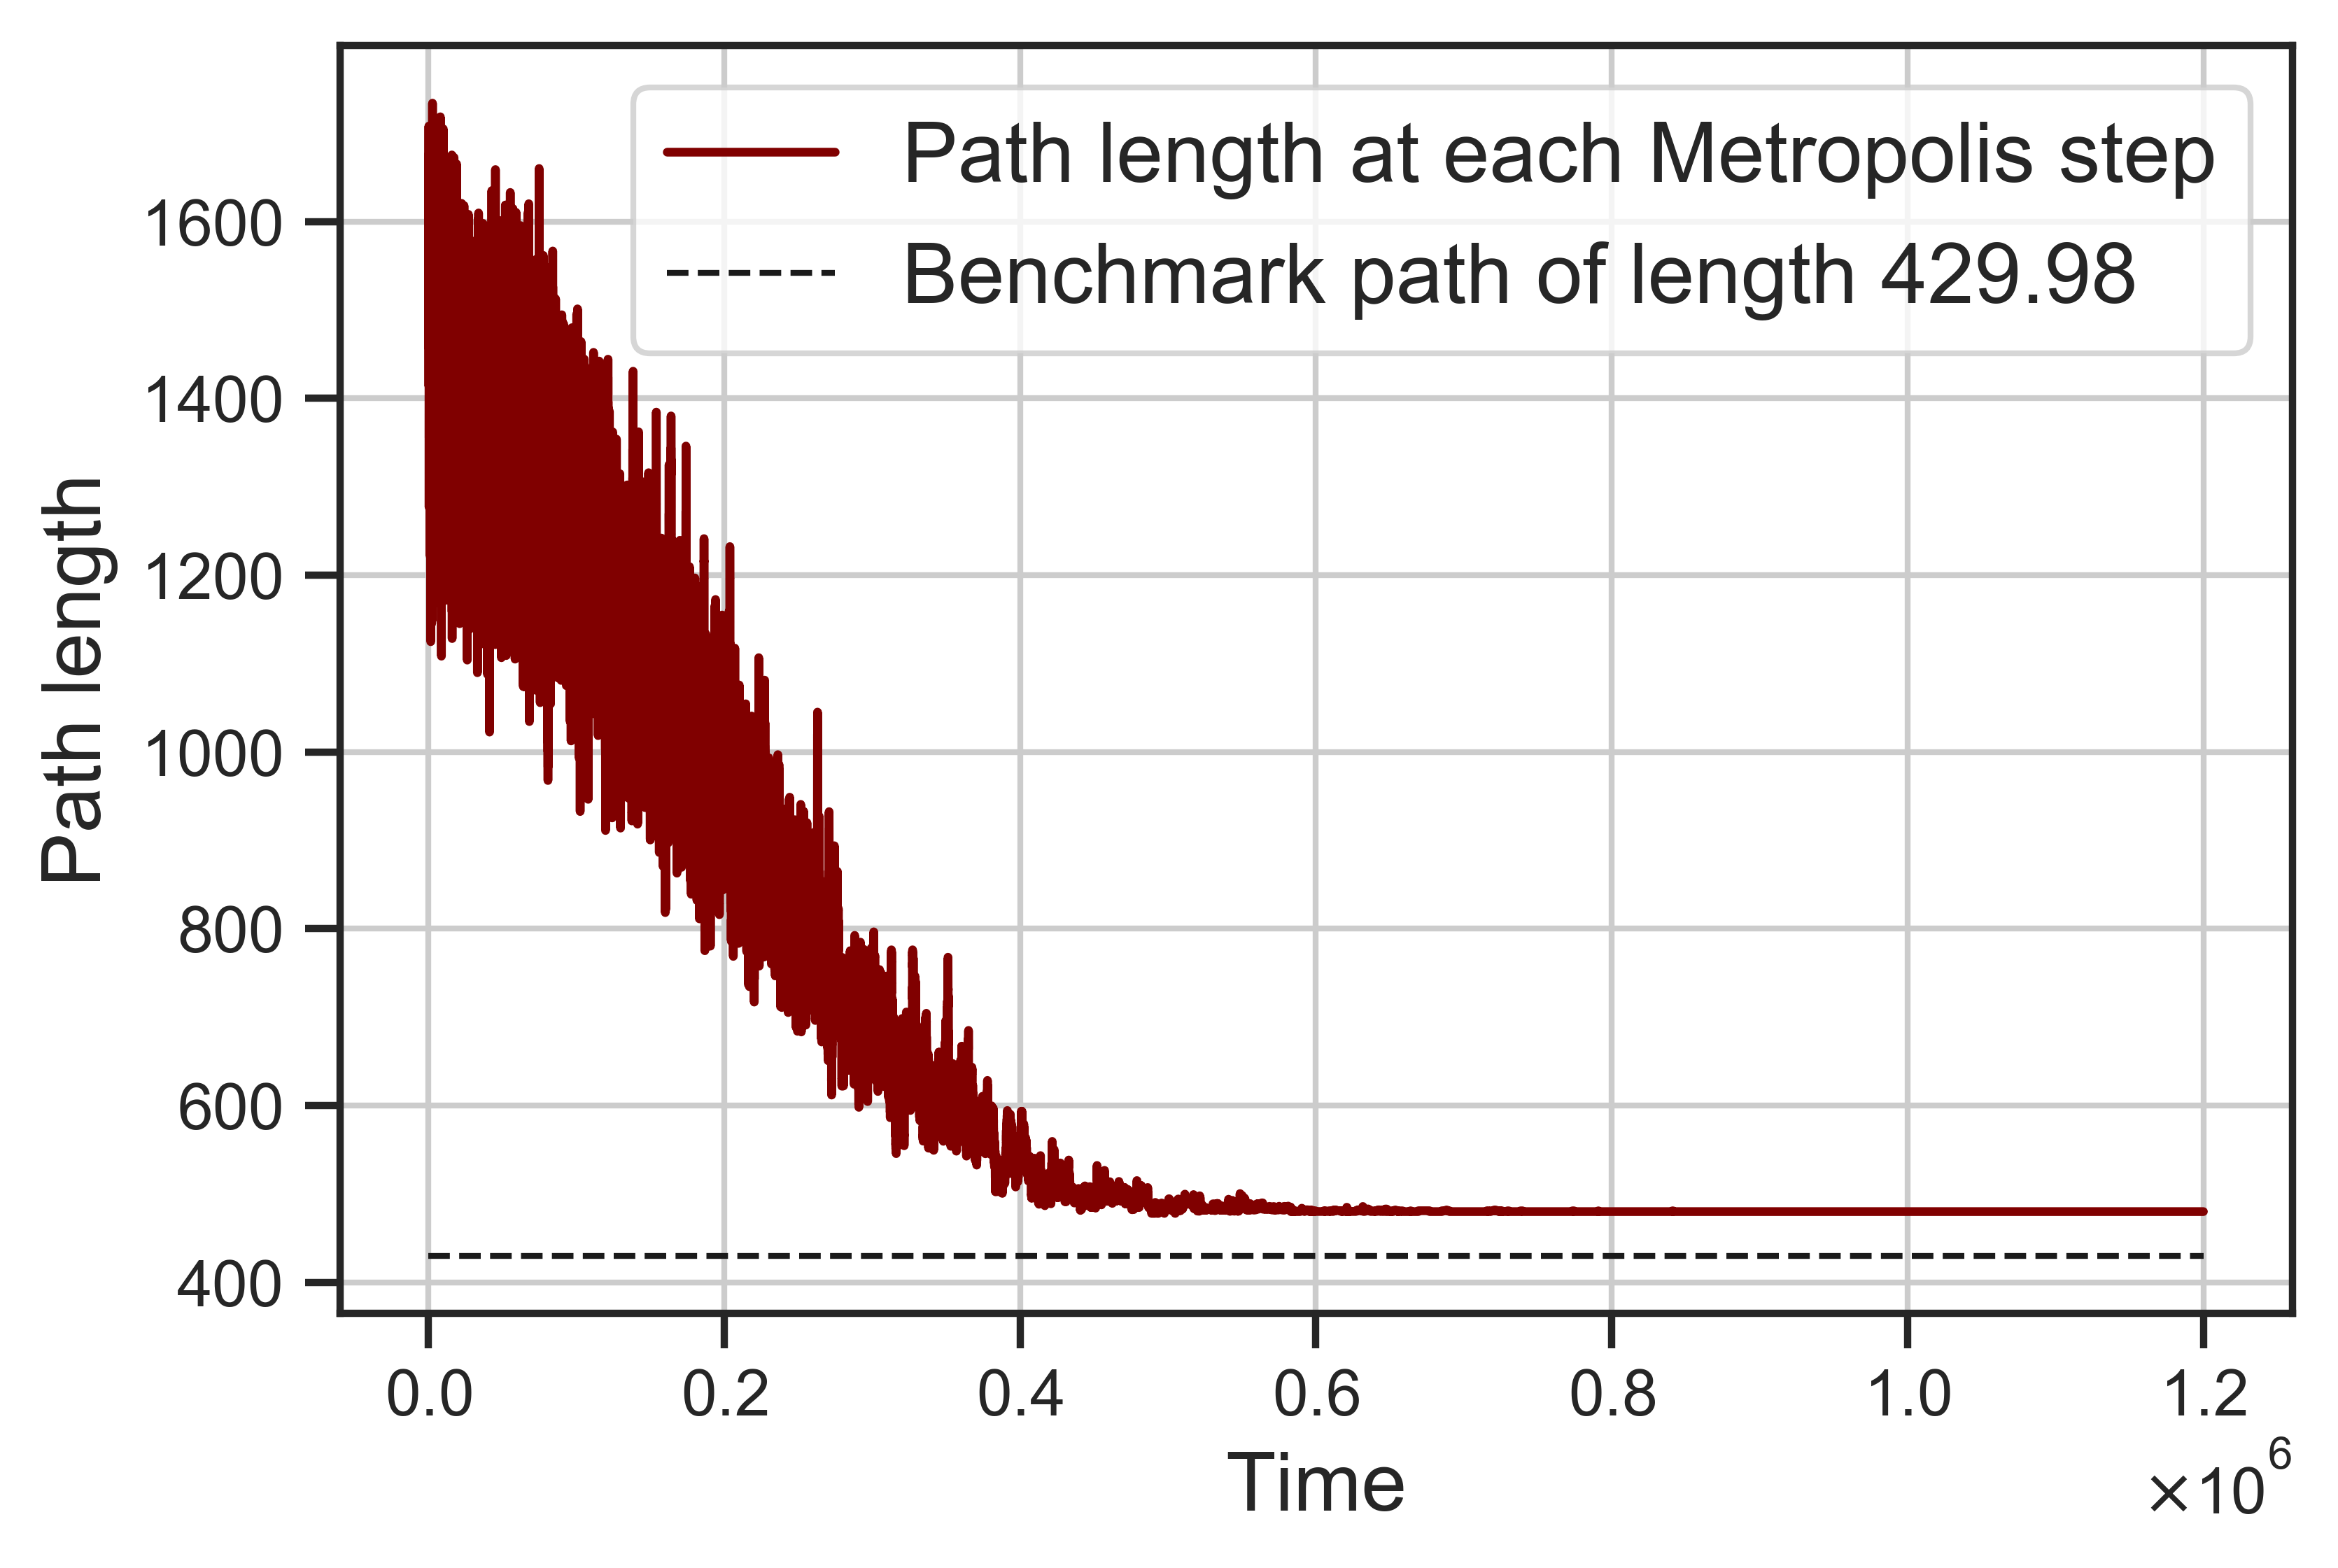

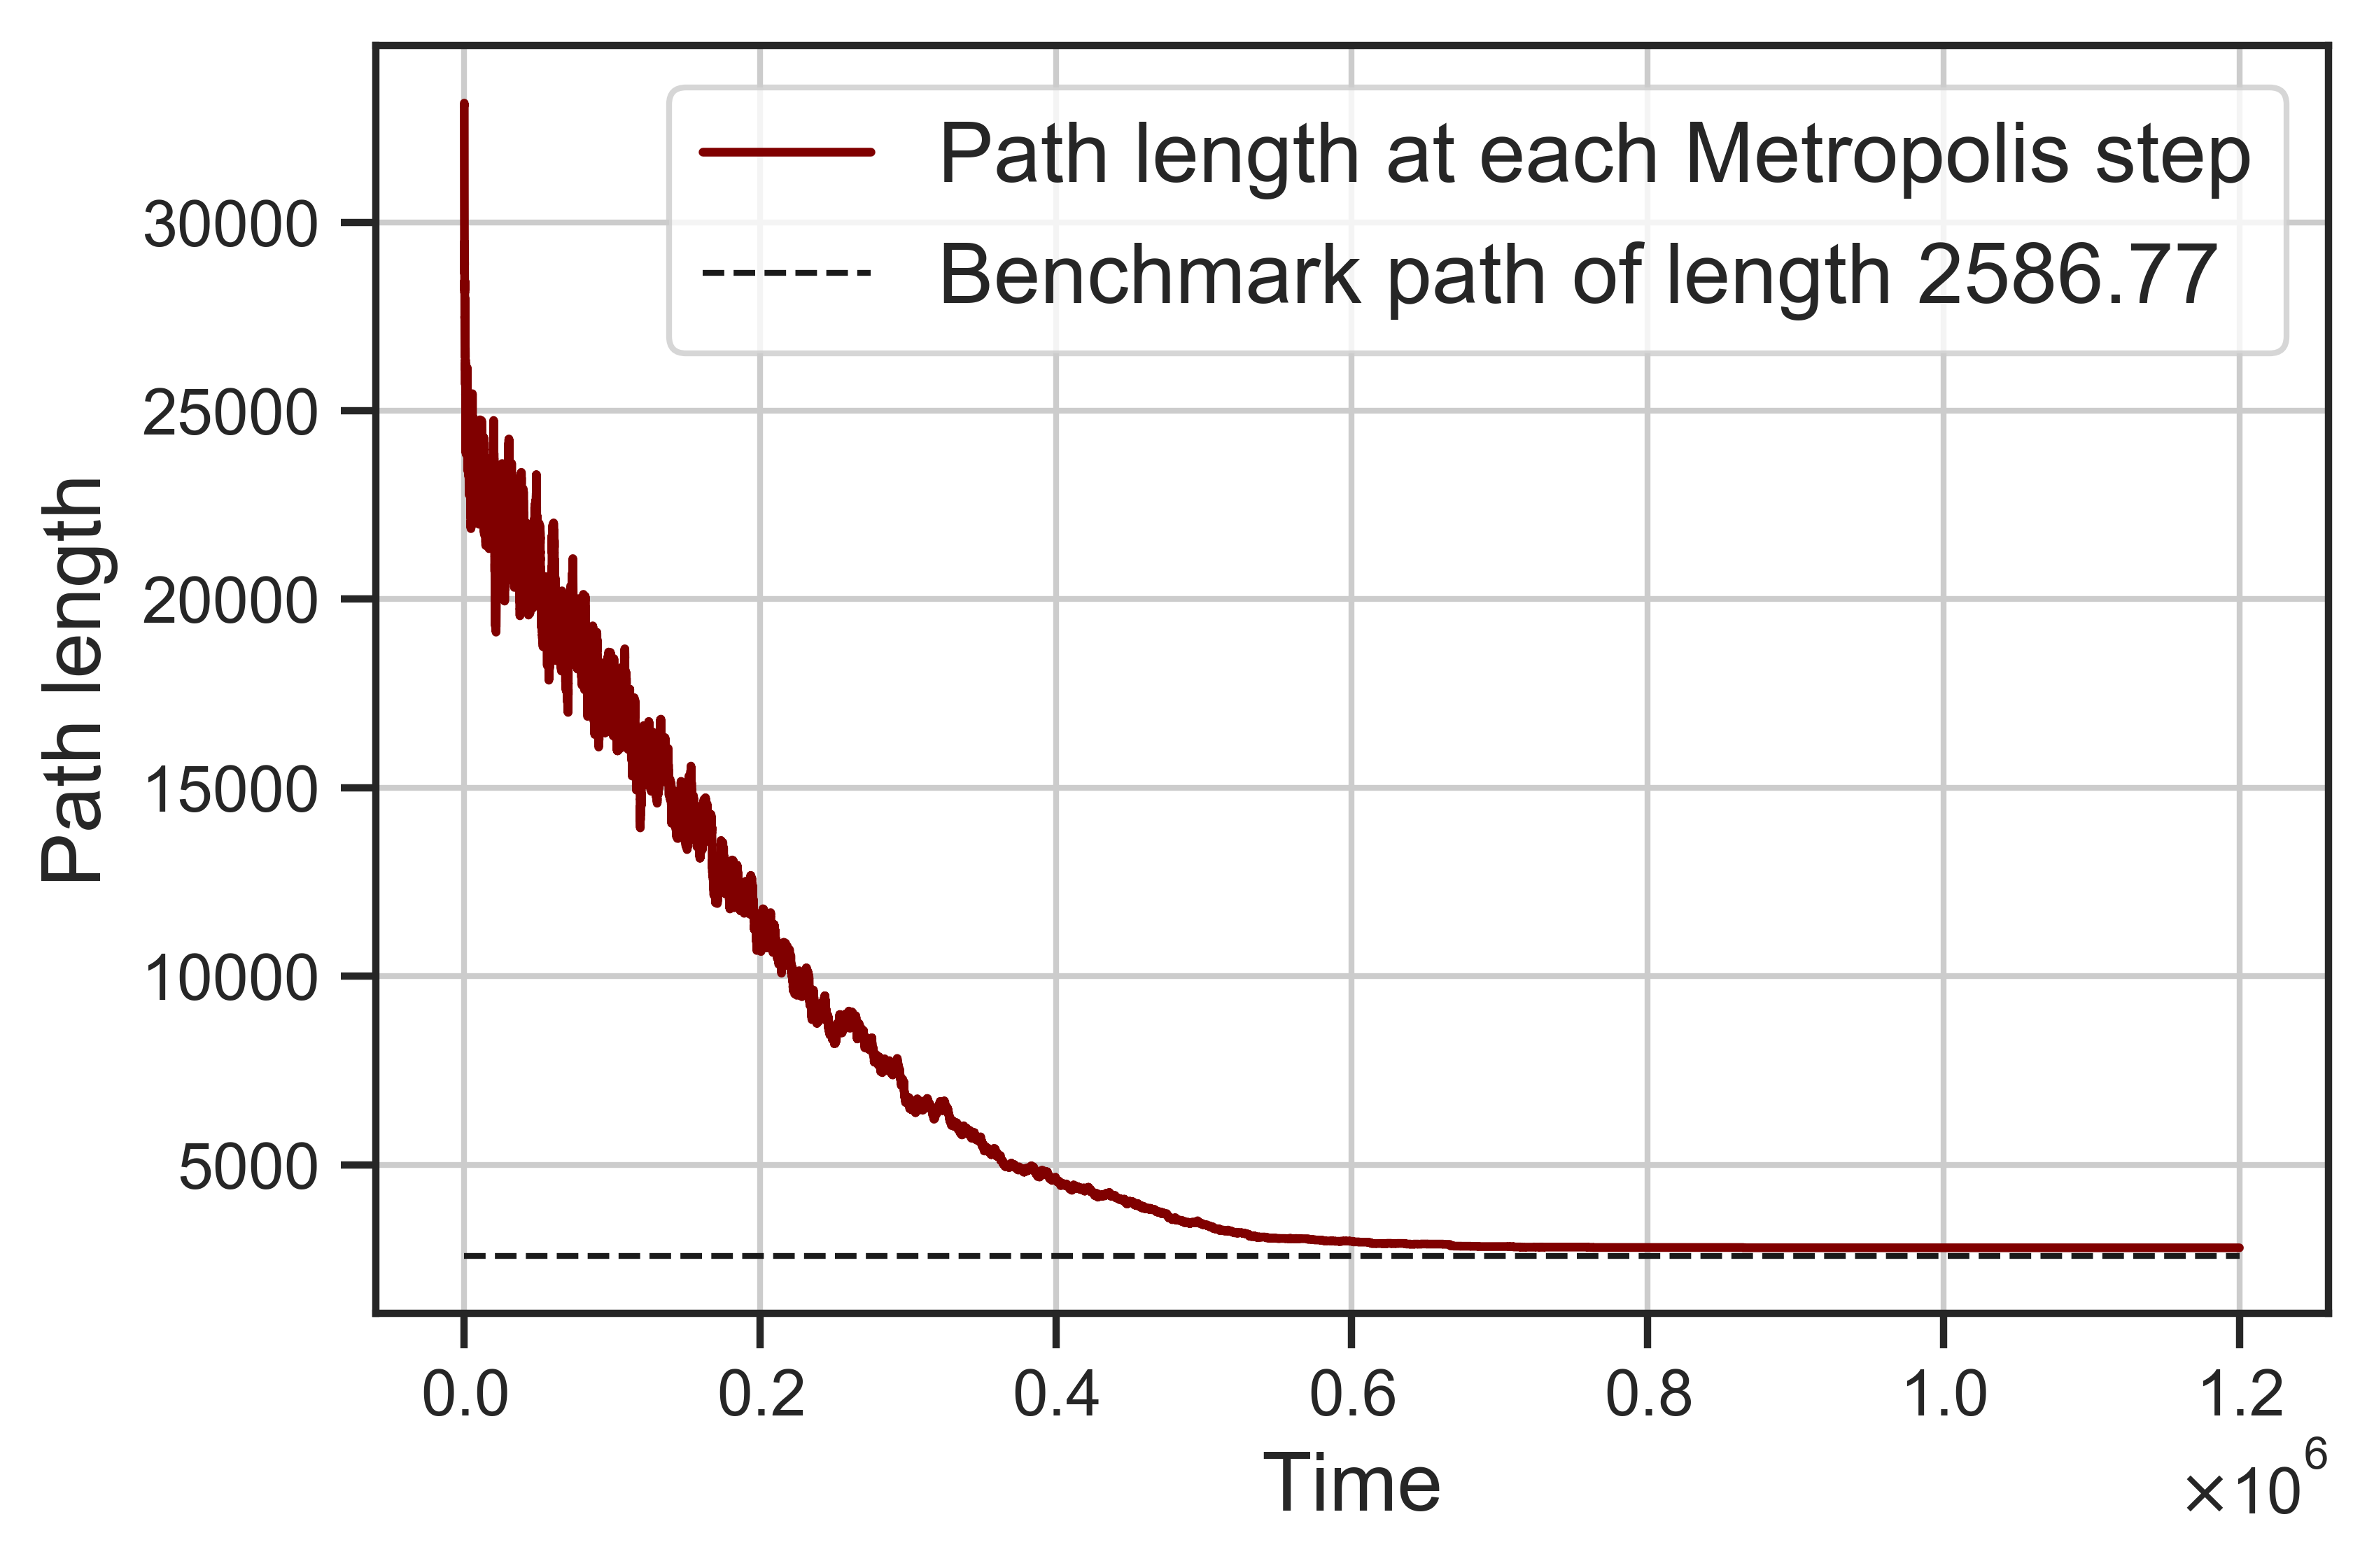

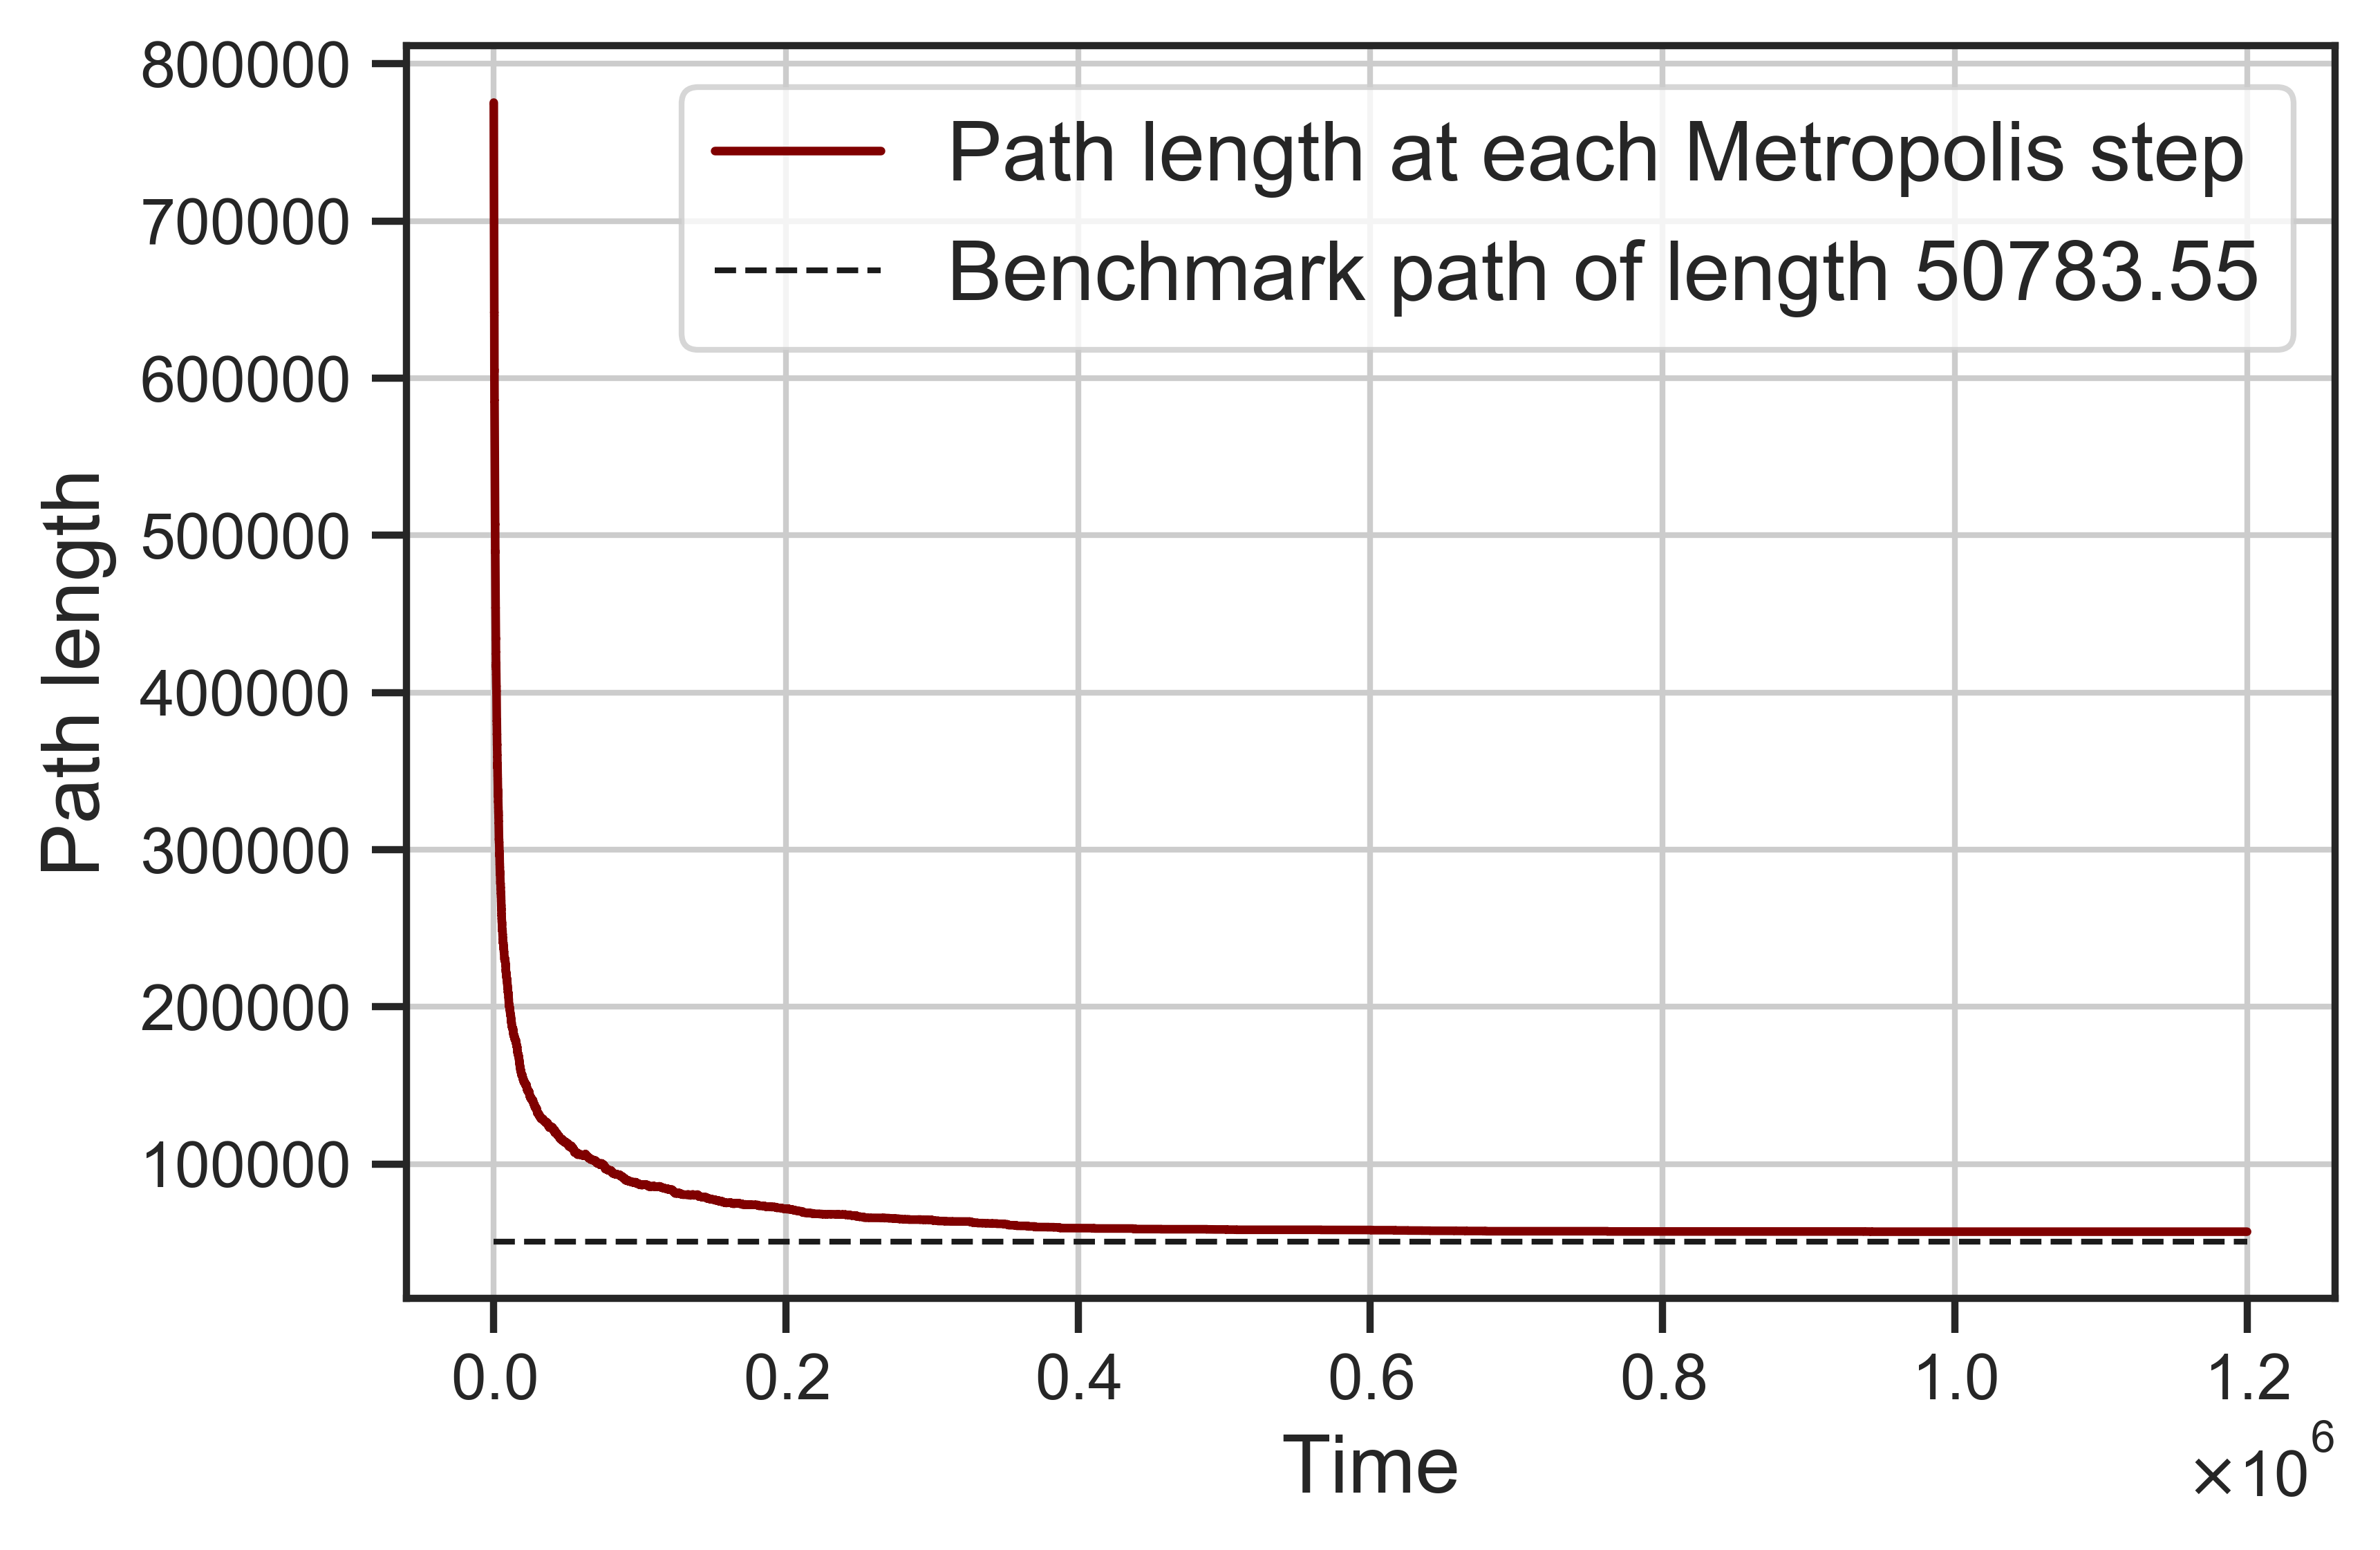

In [34]:
one_sim_convergence(simulated_data = "data_hairy_plot_eil51_All.npz", title = "One_sim_convergence_eil51.pdf")
one_sim_convergence(simulated_data = "data_hairy_plot_a280_All.npz", title = "One_sim_convergence_a280.pdf")
one_sim_convergence(simulated_data = "data_hairy_plot_pcb442_All.npz", title = "One_sim_convergence_pcb442.pdf")

## Final states to plot as paths against given benchmarks for  `eil51.tsp`, `a280.tsp`, `pcb422.tsp`

In [35]:
"""
Preliminary simulation for eil51.tsp: Initial temperature of approx. 35.7, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves final state and corresponding min cost and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[1] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "Final_path_cost_eil51.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    min_cost = sa_system.min_cost
    min_cost_state = sa_system.min_cost_state
    np.savez(npz_filepath, min_cost, min_cost_state)
else:
    save_data = np.load(npz_filepath)
    min_cost = save_data['arr_0']
    min_cost_state = save_data['arr_1']

In [18]:
"""
Preliminary simulation for a280.tsp: Initial temperature of approx. 83.7, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves final state and corresponding min cost and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "Final_path_cost_a280.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    min_cost = sa_system.min_cost
    min_cost_state = sa_system.min_cost_state
    np.savez(npz_filepath, min_cost, min_cost_state)
else:
    save_data = np.load(npz_filepath)
    min_cost = save_data['arr_0']
    min_cost_state = save_data['arr_1']

In [19]:
"""
Preliminary simulation for pcb442.tsp: Initial temperature of approx. 105.1, geometric cooling schedule, MC length of 4000,
and chain count of 300 as a stopping condition.

Saves final state and corresponding min cost and writes a data file. If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[2]
node_count = cost_function.D.shape[1] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

c = 5
T_initial = c * np.sqrt(node_count)

chain_length = 4000
chain_count = 300

rng = generate_rngs(1)[0]

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)

sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "Final_path_cost_pcb442.npz"
npz_filepath = save_path(npz_filename)

if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    min_cost = sa_system.min_cost
    min_cost_state = sa_system.min_cost_state
    np.savez(npz_filepath, min_cost, min_cost_state)
else:
    save_data = np.load(npz_filepath)
    min_cost = save_data['arr_0']
    min_cost_state = save_data['arr_1']

In [36]:
def final_state_vs_benchmark_plotter(simulated_data, title):
    
    """ 
    Plots final state (shortest found path) for eil51.tsp, a280.tsp, pcb442.tsp 
    and corresponding benchmark states.
    
    Uses tsplib95 library to load the coordinates for plotting.
    
    """
    
    filename = simulated_data
    filepath = save_path(filename)
    
    save_data = np.load(filepath)
    
    min_cost = save_data['arr_0']
    min_cost_state = save_data['arr_1']
    
    tour_SA = min_cost_state+1
    
    if simulated_data == "Final_path_cost_pcb442.npz":
        
        tsp_data = tsplib95.load(data_path('pcb442.tsp.txt'))
        _, tour_benchmark = read_tour(OPT_TOUR_FILES[2])
        cost_function, dcost_function = COST_FUNCTION_PAIRS[2]
        
    elif simulated_data == "Final_path_cost_a280.npz":
        
        tsp_data = tsplib95.load(data_path('a280.tsp.txt'))
        _, tour_benchmark = read_tour(OPT_TOUR_FILES[1])
        cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
      
    elif simulated_data == "Final_path_cost_eil51.npz":
        
        tsp_data = tsplib95.load(data_path('eil51.tsp.txt'))
        _, tour_benchmark = read_tour(OPT_TOUR_FILES[0])
        cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
    
        
    nodes = tsp_data.as_name_dict()["node_coords"]
    
    benchmark_cost = cost_function(tour_benchmark)

    tour_Bench = tour_benchmark+1
    tour_Bench = tour_Bench[:-1]


    coordinates_sim = [nodes[tour_SA[i]] for i in range(len(tour_SA))]
    coordinates_benchmark = [nodes[tour_Bench[i]] for i in range(len(tour_Bench))]

    xs_sim = [coord[0] for coord in coordinates_sim]
    ys_sim = [coord[1] for coord in coordinates_sim]

    xs_b = [coord[0] for coord in coordinates_benchmark]
    ys_b = [coord[1] for coord in coordinates_benchmark]


    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10,5))

    for first, second in zip(coordinates_sim[:-1], coordinates_sim[1:]):
        ax1.plot([first[0],second[0]],[first[1],second[1]],"slategray")
    ax1.plot([coordinates_sim[0][0],coordinates_sim[-1][0]],[coordinates_sim[0][1],coordinates_sim[-1][1]],"slategray")
    ax1.scatter(xs_sim, ys_sim,  color = "darkred", marker = "h", s = 19)
    ax1.set_title('Final state with path length of {:.2f}'.format(min_cost), size = 13)
    ax1.set_xlabel("x") #, size = 14)
    ax1.set_ylabel("y") #, size = 14)
    ax1.tick_params(axis='y', rotation=45)
    ax1.tick_params(axis='x', rotation=45)

    # for i, txt in enumerate(pcb442_tour_SA):
    #     plt.annotate(txt, (xs[i], ys[i]))


    for first, second in zip(coordinates_benchmark[:-1], coordinates_benchmark[1:]):
        ax2.plot([first[0],second[0]],[first[1],second[1]],"green")
    ax2.plot([coordinates_benchmark[0][0],coordinates_benchmark[-1][0]],[coordinates_benchmark[0][1],coordinates_benchmark[-1][1]],"green")
    ax2.scatter(xs_b, ys_b, color = "darkred", marker = "h", s = 19)
    ax2.set_title('Benchmark path of length {:.2f}'.format(benchmark_cost), size = 13)
    ax2.set_xlabel("x") #, size = 14)
    ax2.set_ylabel("y") #, size = 14)
    ax2.tick_params(axis='y', rotation=45)
    ax2.tick_params(axis='x', rotation=45)

    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

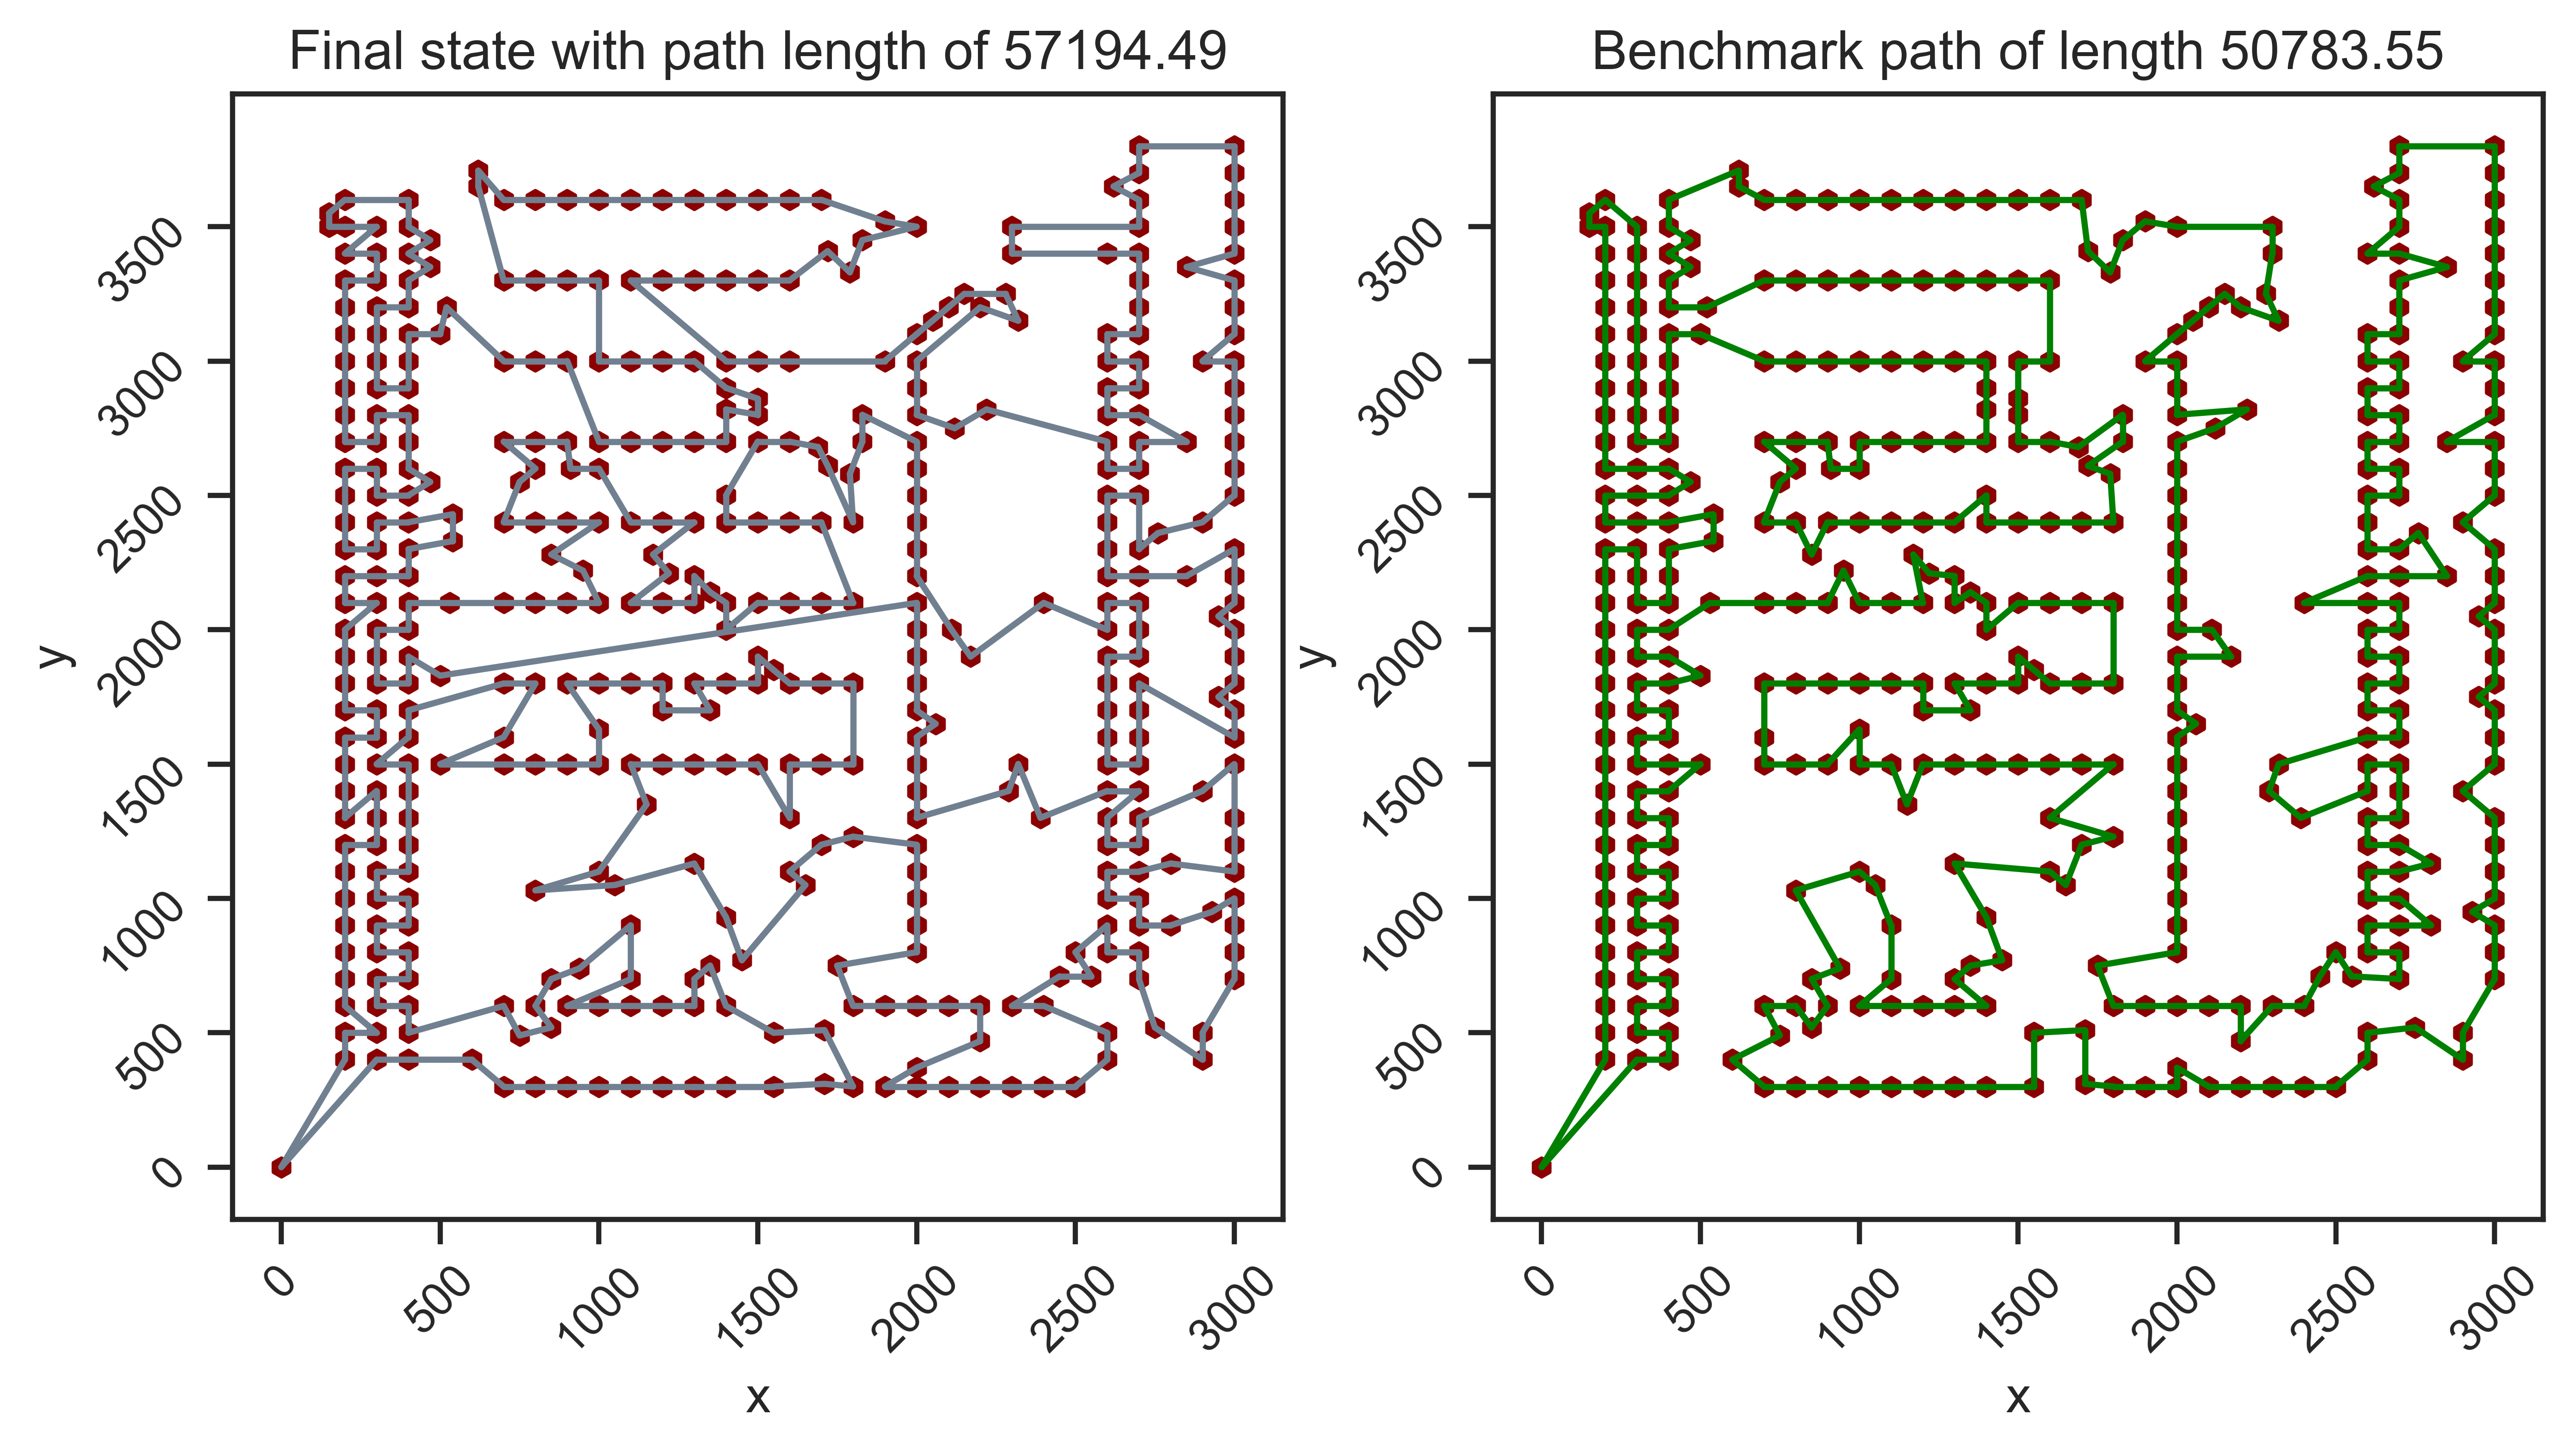

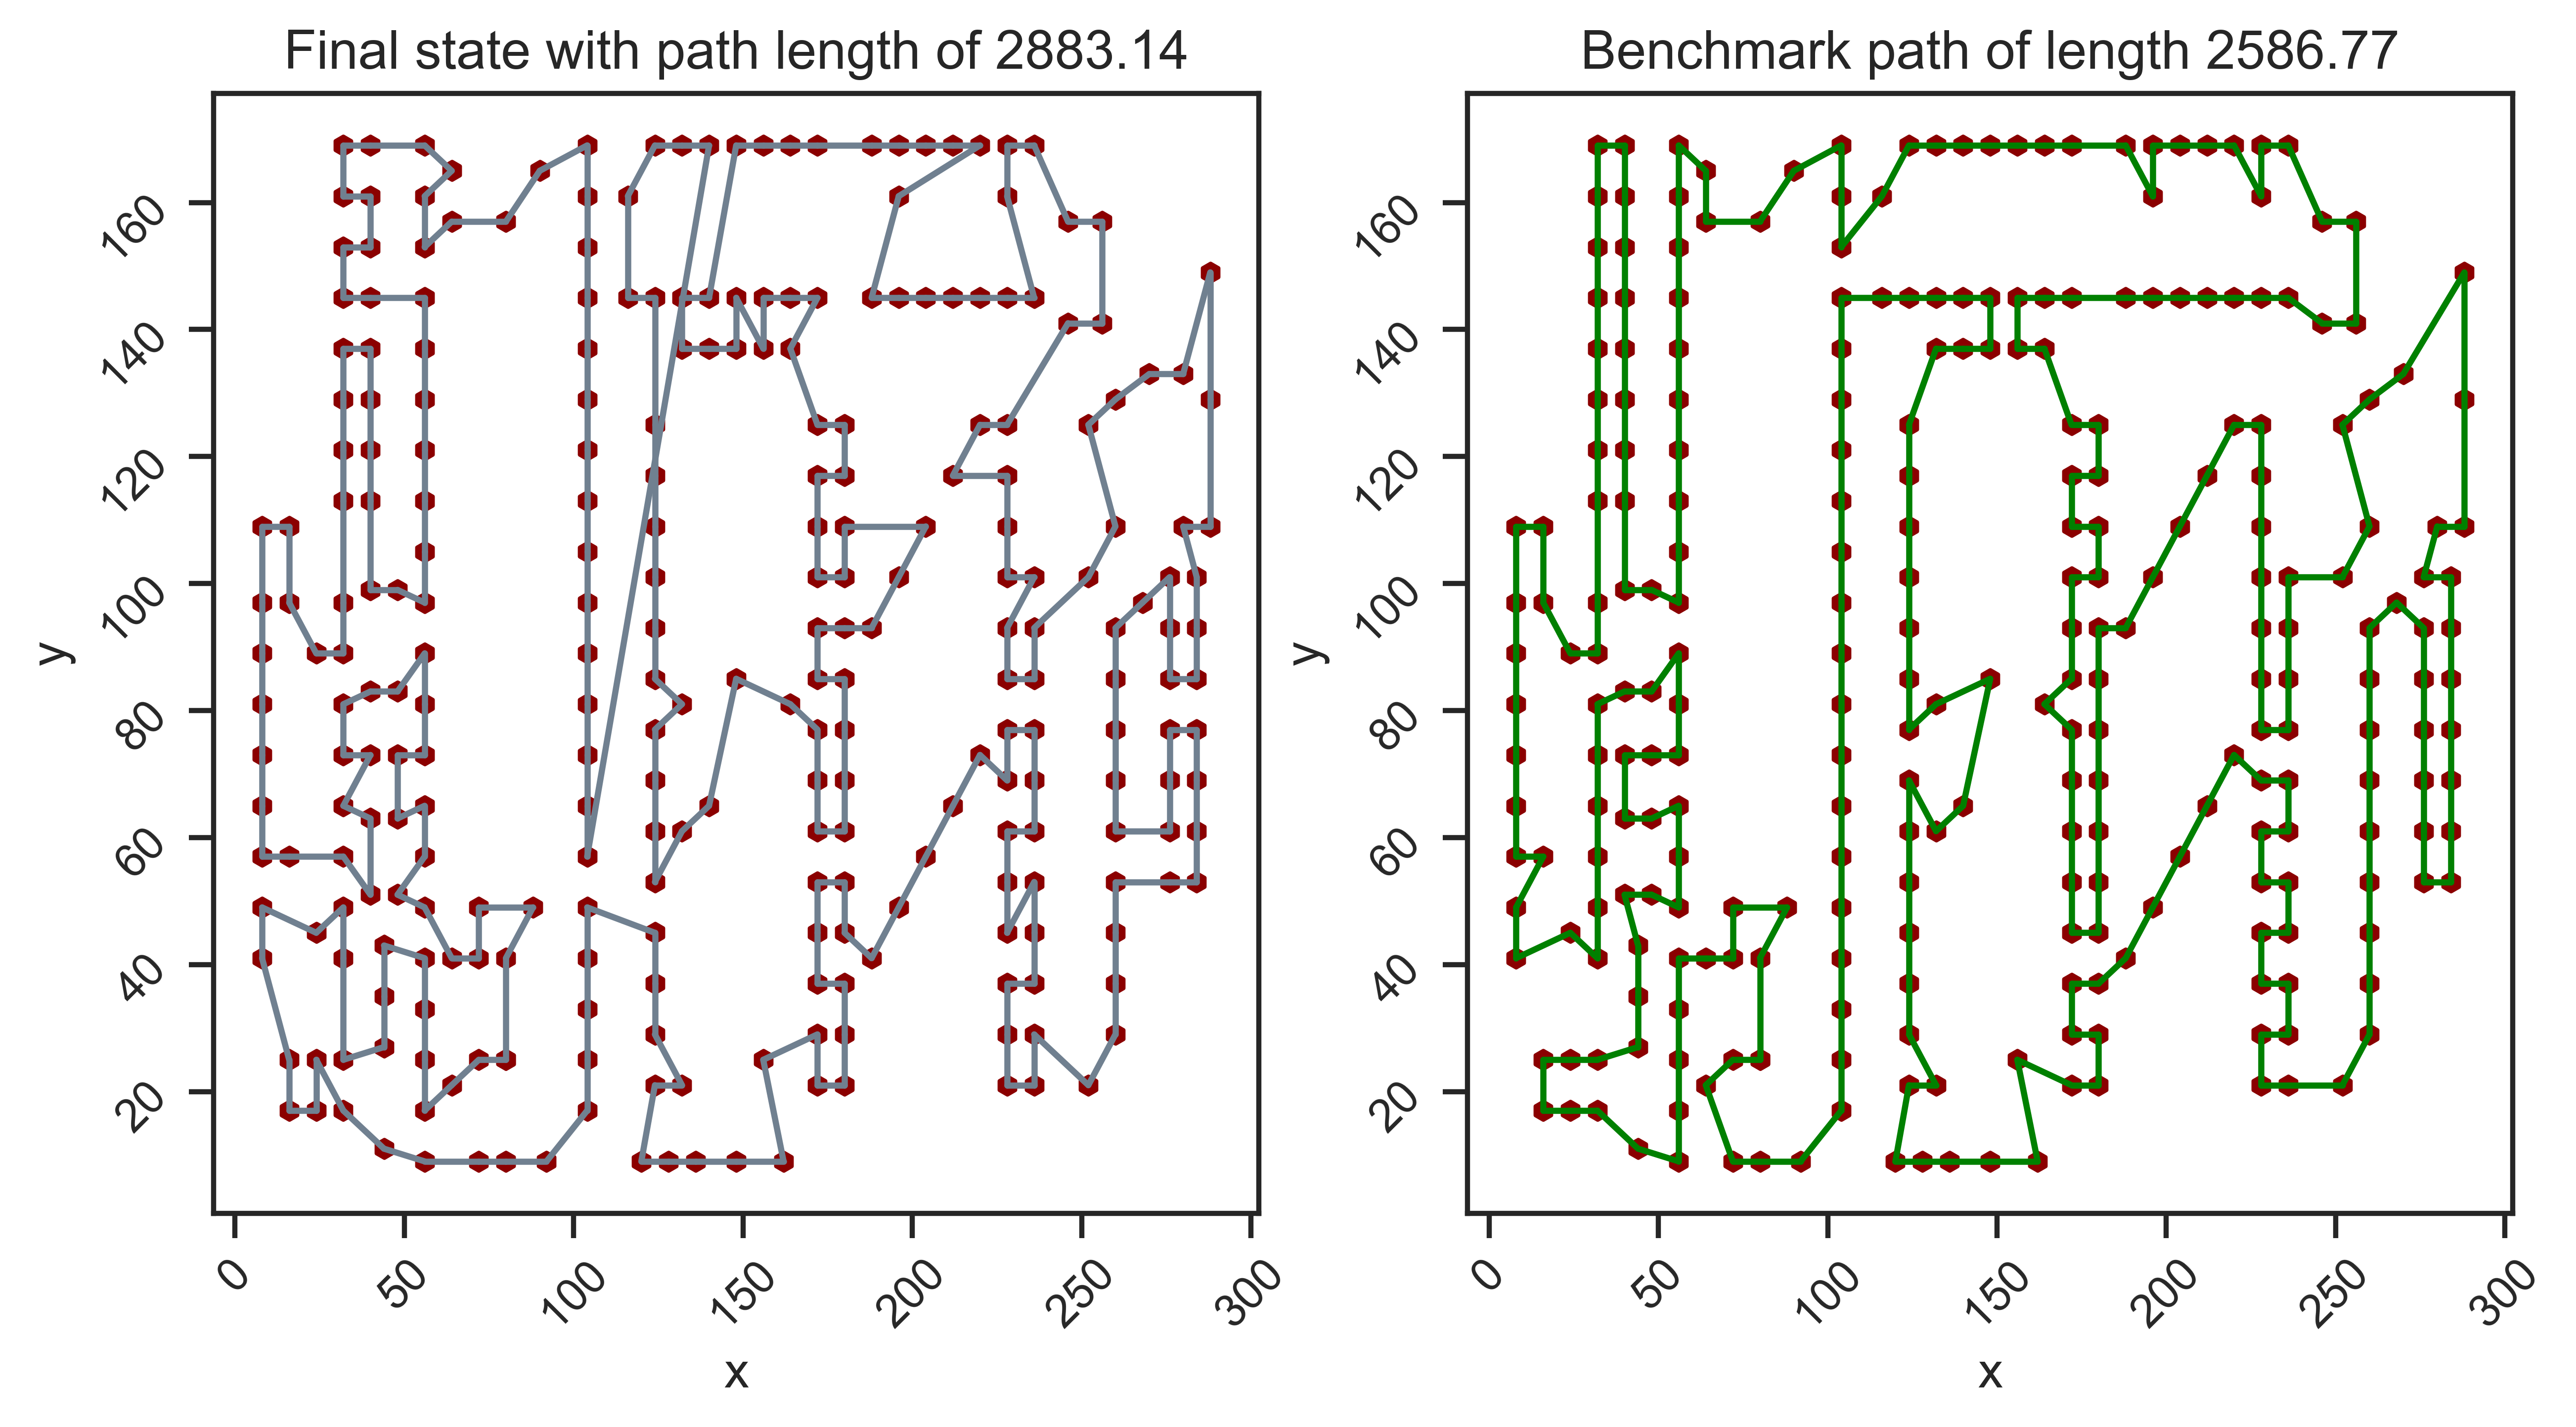

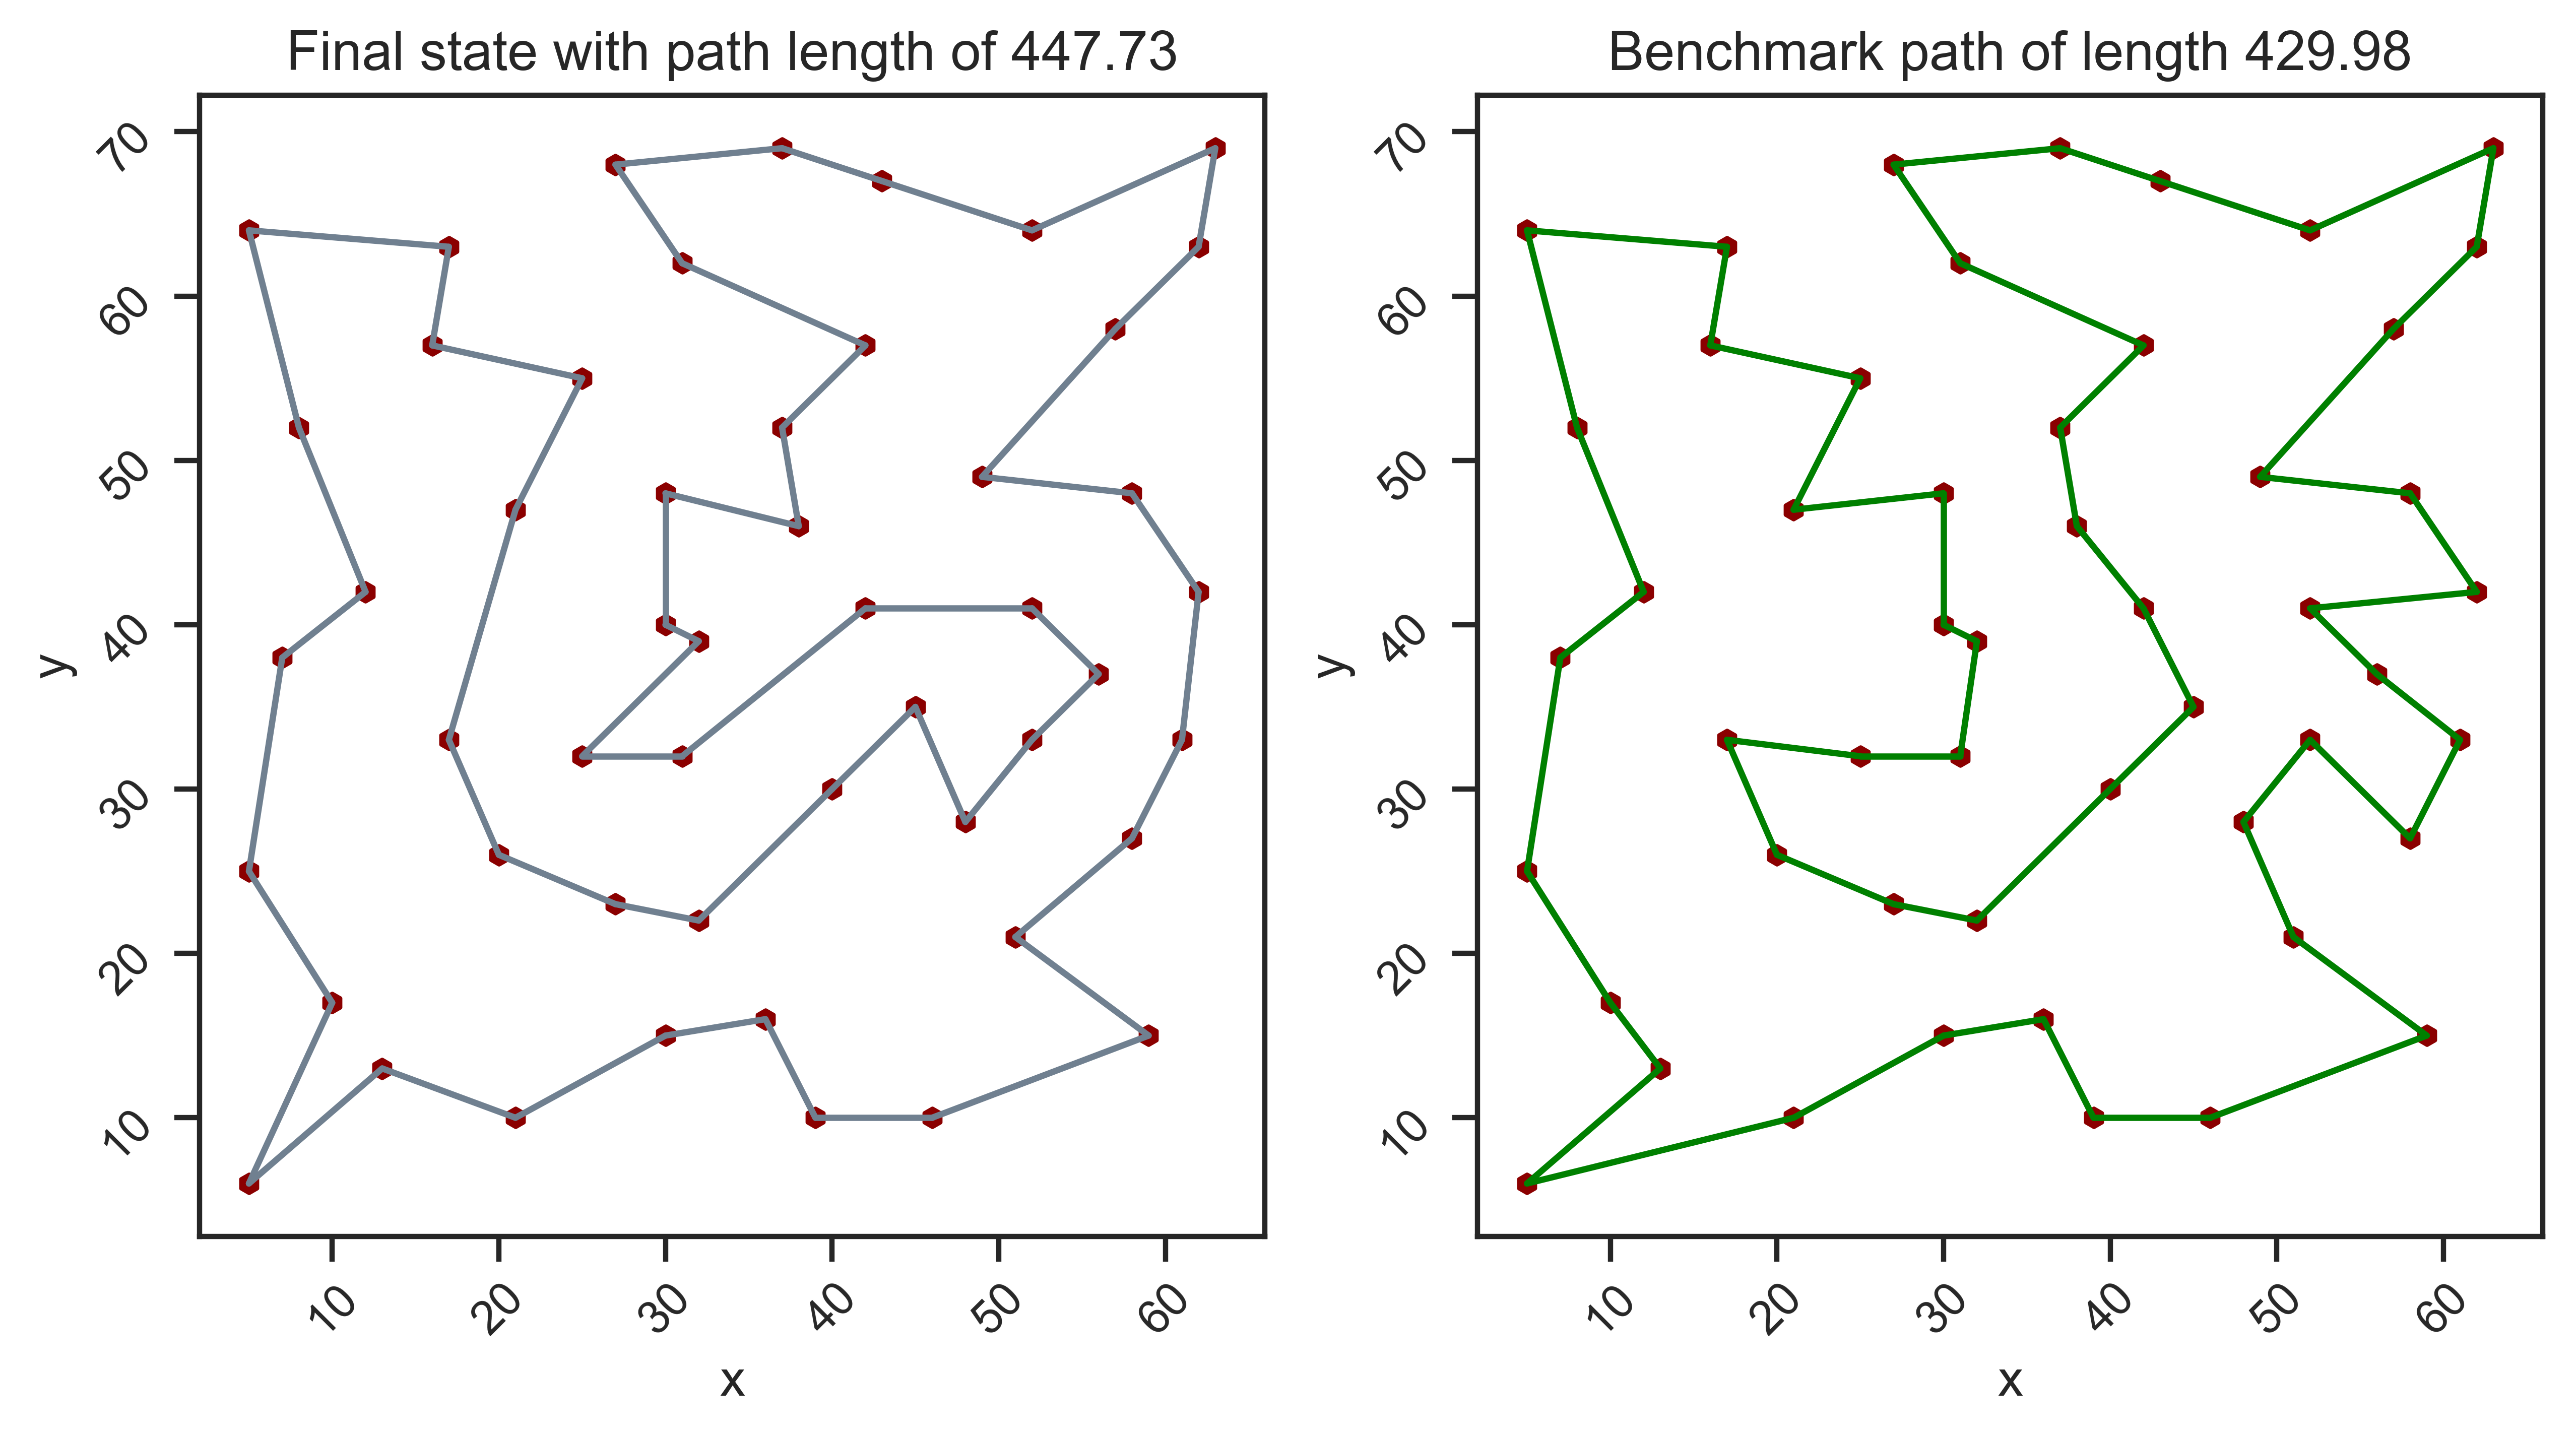

In [37]:
final_state_vs_benchmark_plotter(simulated_data = "Final_path_cost_pcb442.npz", title = "Final_path_pcb442.pdf")
final_state_vs_benchmark_plotter(simulated_data = "Final_path_cost_a280.npz", title = "Final_path_a280.pdf")
final_state_vs_benchmark_plotter(simulated_data = "Final_path_cost_eil51.npz", title = "Final_path_eil51.pdf")


## Main analysis: `a280.tsp`
## Data for plots: 
- Different Makrov Chain lengths and min cost
- Different Makrov Chain lengths and initial acceptance ratio

In [40]:
"""
Primary simulation for a280.tsp: Initial temperature of approx. 83.7, geometric cooling schedule,
varying Markov chain lengths and chain count of 300 as a stopping condition, 40 runs.

Saves shortest path length (cost) for each Markov chain length and writes a data file. 
If the file exists, loads it.

"""

cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)
c = 5
T0 = c * np.sqrt(node_count)

chain_length_values = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000], dtype = np.int32)
chain_count = 300
batch_size = 40

DEFAULT_TRANSITIONS = (random_two_opt_transition, Lin2opt)
transition, state_constructor = DEFAULT_TRANSITIONS # default
 
rngs = generate_rngs(len(chain_length_values))

args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)

min_cost_list = []
acceptance_rates_list = []
npz_filename = "differnt_mc_lengths.npz"
npz_filepath = save_path(npz_filename)

if not exists(npz_filepath):
    for i, chain_length in enumerate(chain_length_values):
        sa_system = SAMinimizer(transition, dcost_function, cooling_schedule, rngs[i].uniform, state_constructor)
        min_costs, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, min_cost_list, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        min_cost_list = save_data['arr_0']
        acceptance_rates_list = save_data['arr_1']


In [23]:
def markov_chain_length_cost_plotter(simulated_data, title):
    
    """ 
    Plots horizontal boxplot with observations, where data points are min cost of each of 40 runs.
    
    """
    
    filename = simulated_data 
    filepath = save_path(filename)

    data = np.load(filepath)['arr_0']
    df = pd.DataFrame(np.transpose(data), columns = ["500", "1000", "1500", "2000", "2500", "3000", "3500", "4000", "4500", "5000", "5500", "6000", "6500", "7000"])
    df_long = df.melt(var_name='ChainLength',value_name='Shortest path')

    sns.set_theme(style="ticks")

    f, ax = plt.subplots() #figsize=(7, 6)

    sns.boxplot(y = "ChainLength",
                x = "Shortest path", data = df_long, whis=[0, 100], width=.6, palette="coolwarm")

    sns.stripplot(x="Shortest path", y="ChainLength", data=df_long,
                  size=4, color=".3", linewidth=0)

    ax.xaxis.grid(True)
    ax.set(ylabel="Markov chain length")
    sns.despine(trim=True, left=True)
    ax.tick_params(axis='x', rotation=45)

    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()
    

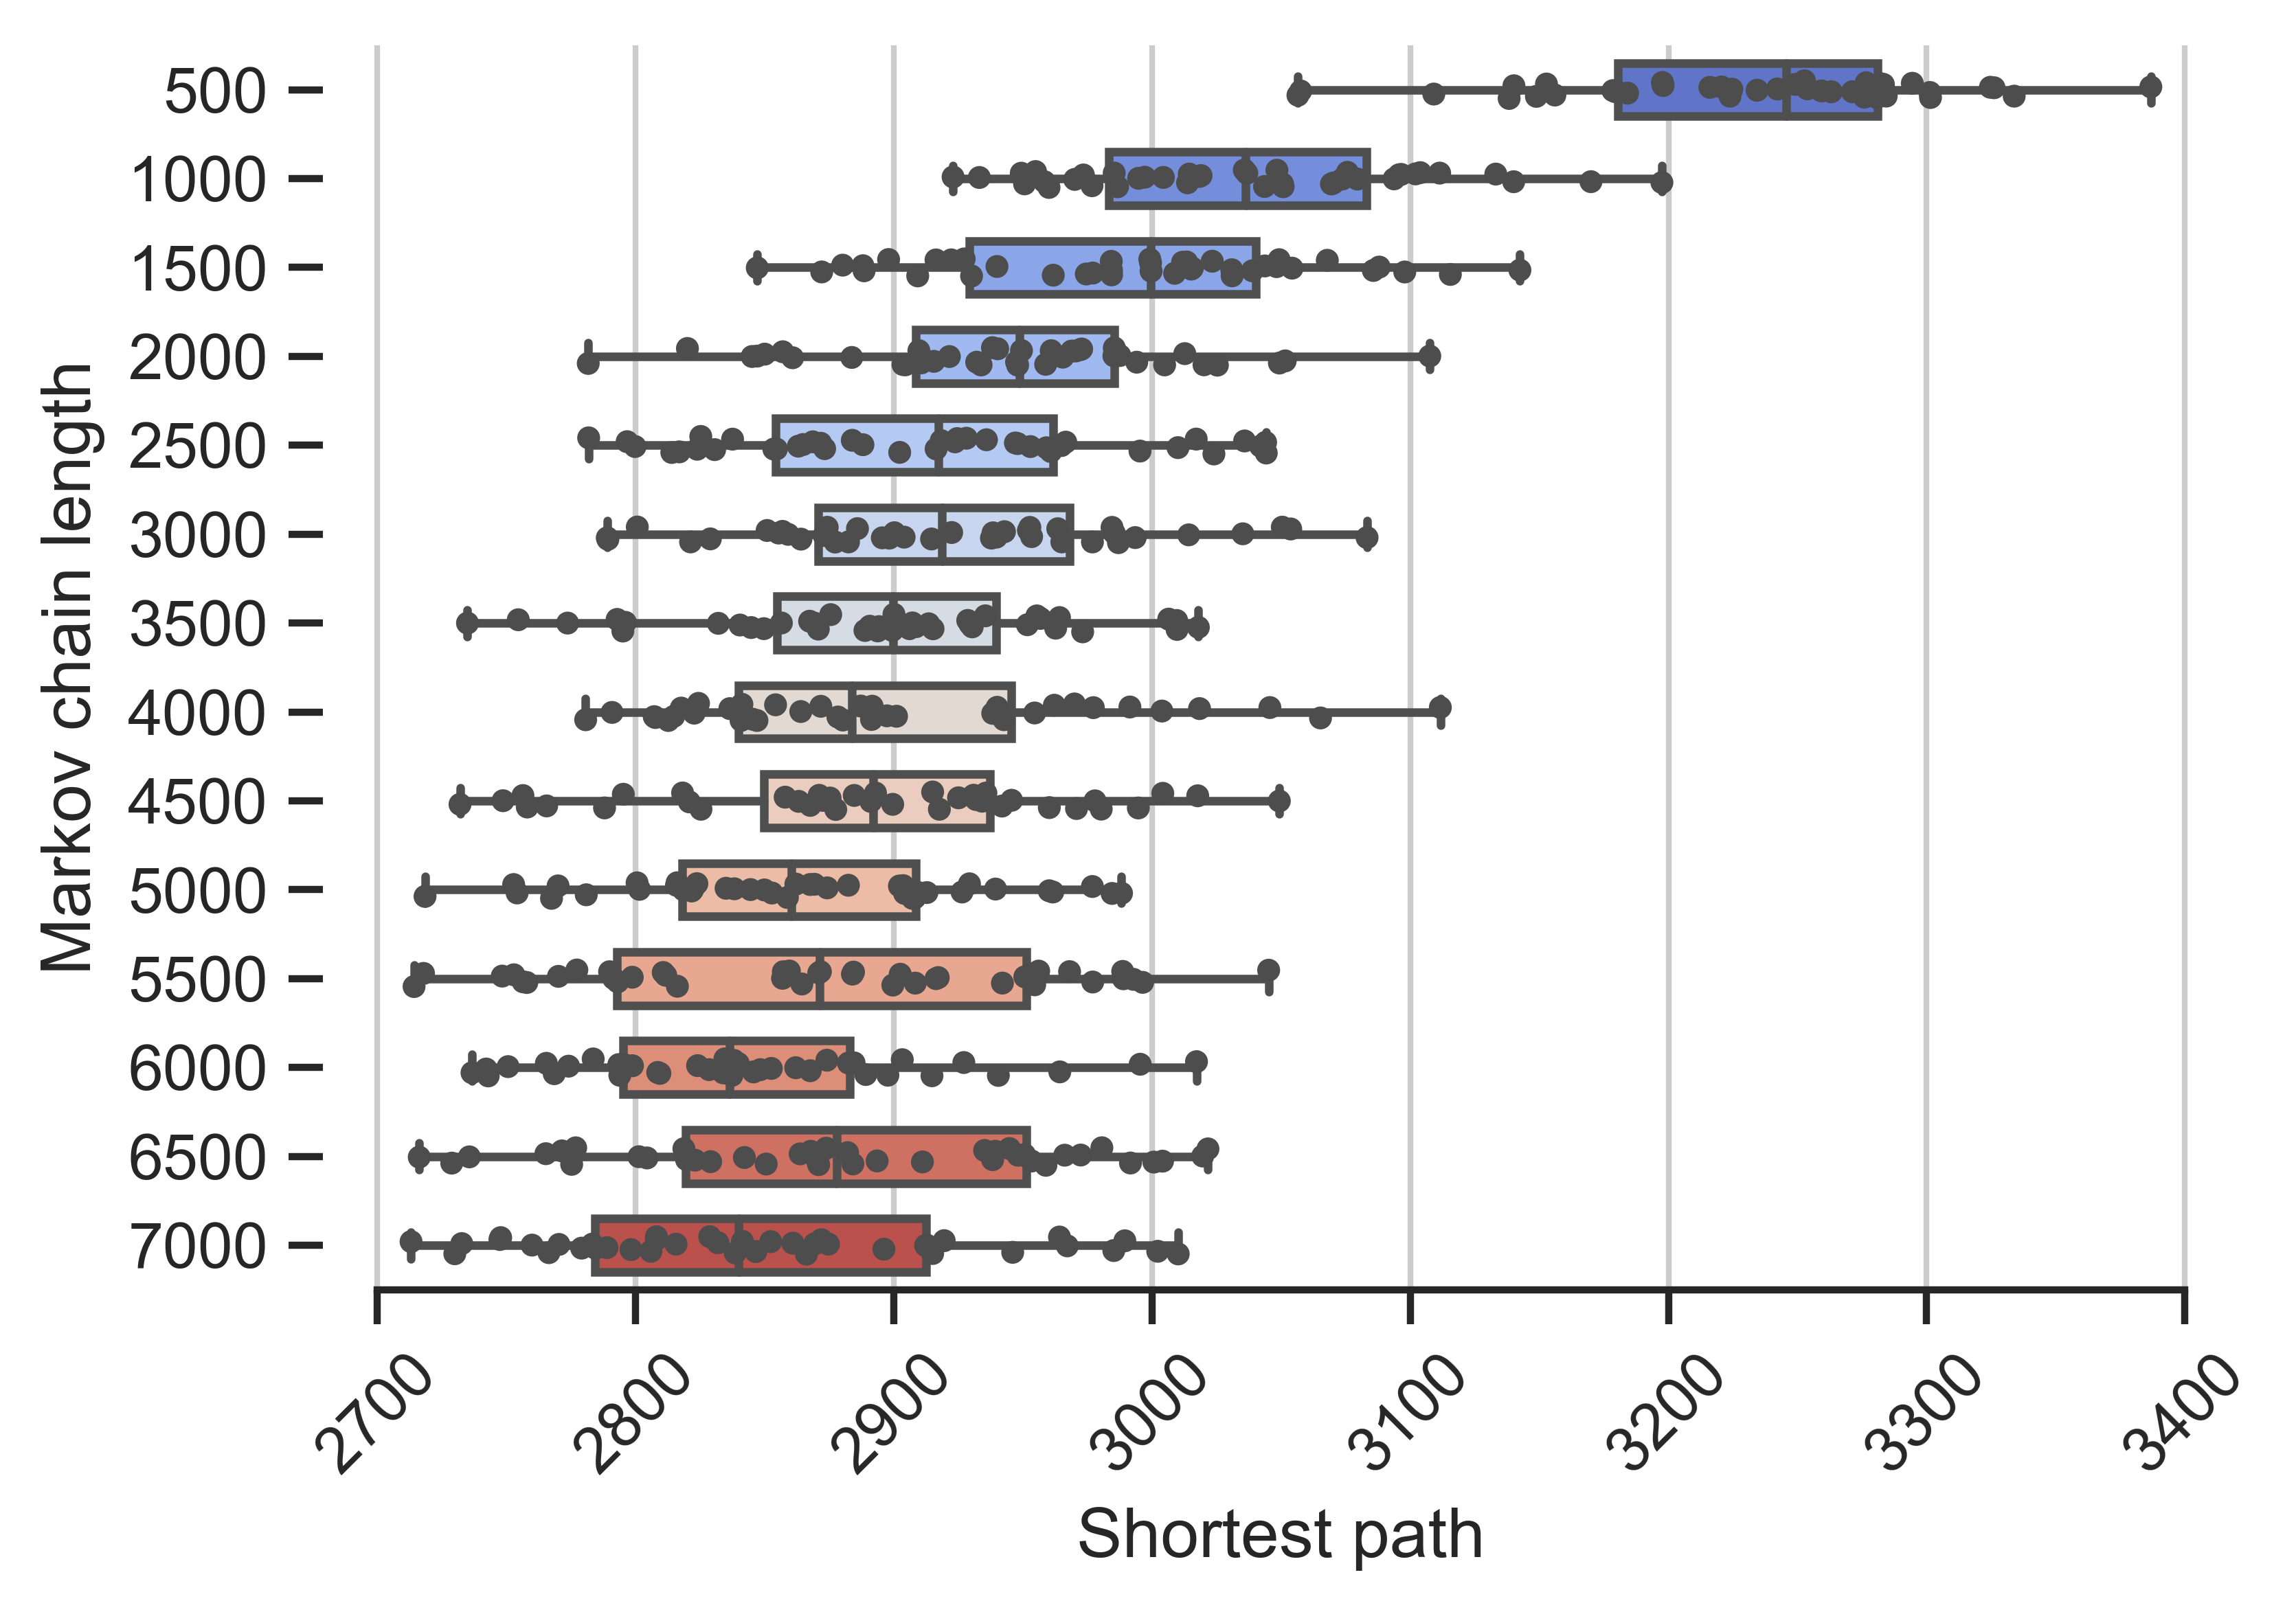

In [24]:
markov_chain_length_cost_plotter(simulated_data = "differnt_mc_lengths.npz", title = "MC_length_cost_boxplot.pdf")

In [47]:
def markov_chain_acceptance_rate_plotter(simulated_data, title):
    
    """ 
    Plots mean initial acceptance rate and SD for varying Markov chain lengths.
    
    """
    
    filename = simulated_data
    filepath = save_path(filename)

    acceptance_rates_list = np.load(filepath)['arr_1']
    
    mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
    std_acc_rates = np.std(acceptance_rates_list, axis = 1)

    plt.errorbar(chain_length_values, mean_acc_rates, yerr=std_acc_rates, linestyle="dashed", linewidth = 1, marker='o', capsize=3, markersize="6", mfc='brown', color='brown', label = "Acceptance rate of 40 simulations")
    plt.fill_between(chain_length_values, mean_acc_rates-std_acc_rates, mean_acc_rates+std_acc_rates, alpha=.25, color="indianred")
    plt.xlabel("Chain length")
    plt.ylabel("Mean acceptance rate and SD") #TODO: initial acceptance rate
    plt.legend()
    plt.grid()
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.xticks(rotation=45)
    
    plt.show()

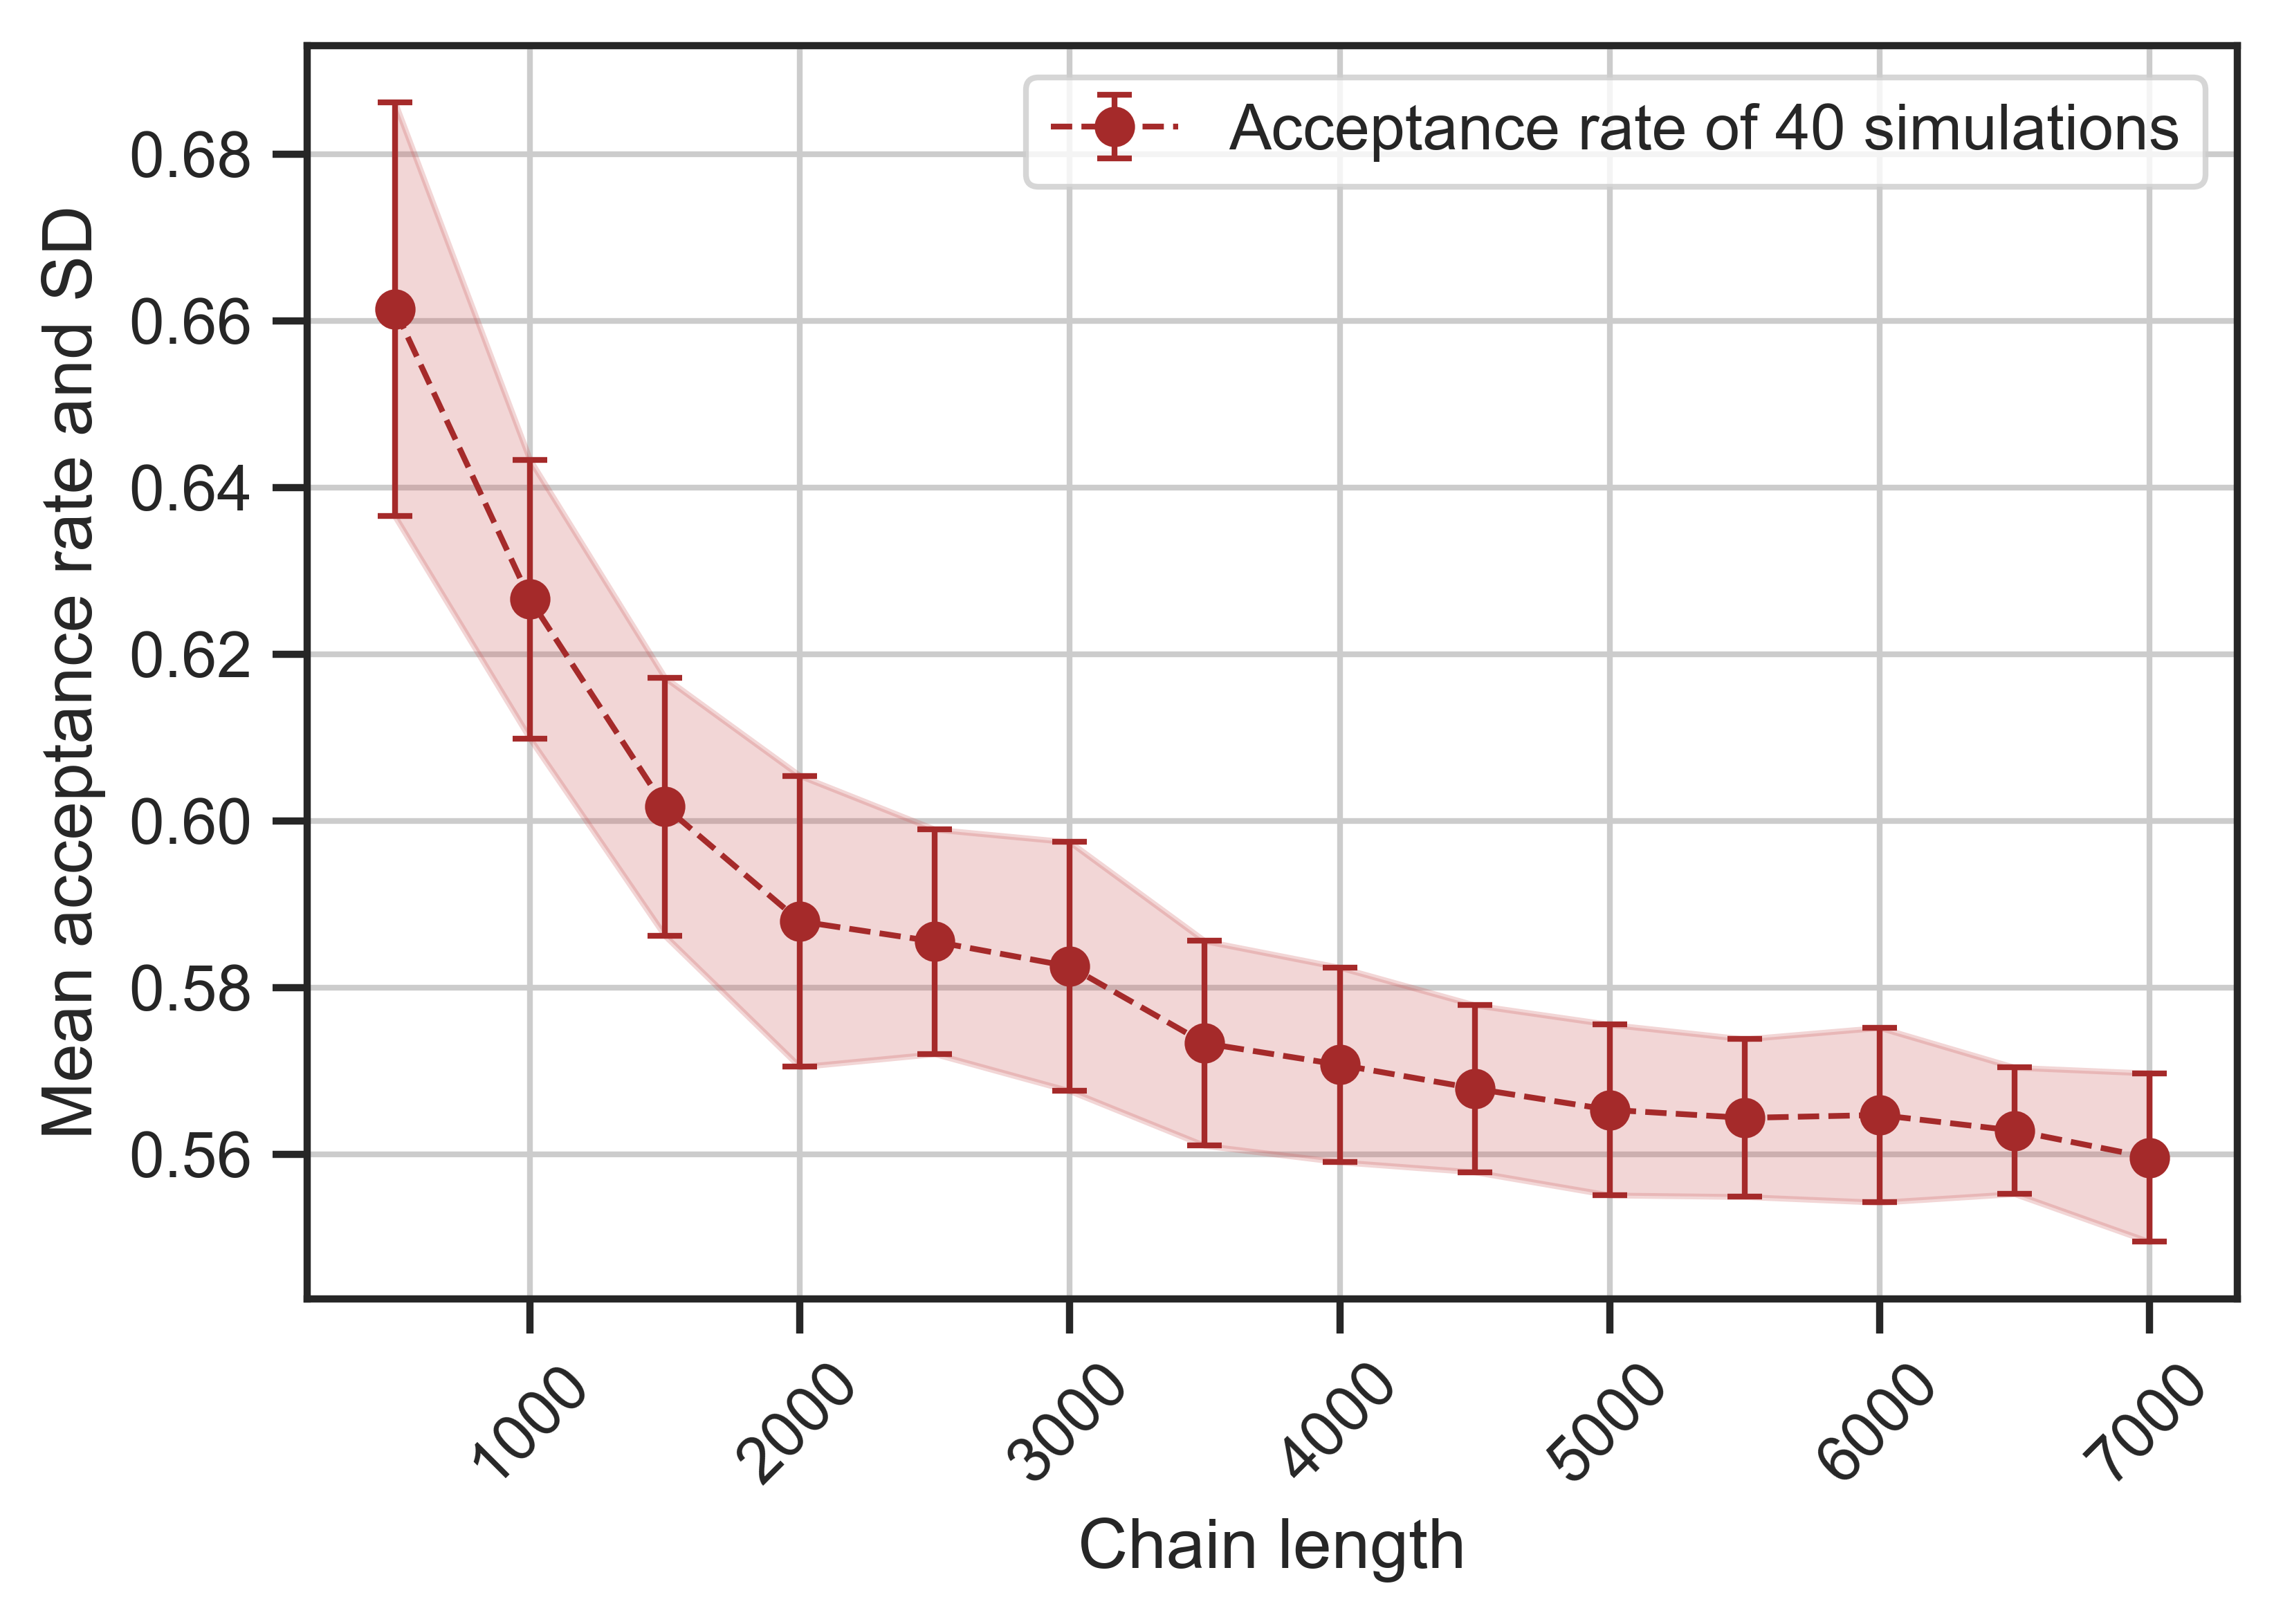

In [48]:
markov_chain_acceptance_rate_plotter(simulated_data = "differnt_mc_lengths.npz", title = "MC_length_acceptance_rate.pdf")

## Preliminary tests: not used directly in the report

- used to understand the behavior of the algorithm prior tuning it.

### Initial temperature and initial acceptance rate: `a280.tsp`

In [49]:
# a280, cr=0.95 from 0.975, chain count 600
cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.linspace(1,10,10)[3:9]
T_initial_values = c_values * np.sqrt(node_count)


rngs = generate_rngs(len(T_initial_values))

batch_size = 10
min_costs_list = []
chain_length = 1000
chain_count = 600
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
npz_filename = "a280_different_constants_cr_095.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    # TODO: parallelize this loop
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, min_cost_list, acceptance_rates_list)

else:
    save_data = np.load(npz_filepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']

In [50]:
save_data = np.load(npz_filepath)
min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']
print(min_cost_list)
print(acceptance_rates_list)

c_values = np.linspace(1,10,10)[3:9]
T_initial_values = c_values * np.sqrt(node_count)
print(T_initial_values)

abs_min_costs = np.min(min_cost_list, axis = 1)
print(abs_min_costs)

[[2939.64171524 2953.94546035 3015.18862278 3181.71871658 3116.93419104
  3004.17038743 2908.58391854 3122.76478772 2991.5550904  3086.01695215]
 [3011.42855148 3011.32145703 3020.00891314 2946.12905436 3108.09815778
  3002.79914795 2856.06316733 2883.49448696 2835.45240024 2933.92020673]
 [2912.86627198 3014.30141417 3068.62782339 3079.28724664 3181.86247722
  3015.45488868 2972.65530388 2997.67947337 2961.53868    2998.1008034 ]
 [2988.8463146  2916.91178813 2843.90498182 3010.6543298  2991.15320583
  2967.36292615 2954.01909941 2940.63381187 2987.93355578 3089.18254061]
 [3079.78373539 3079.37587722 3066.89578518 3012.35496994 3088.05852177
  2955.04062351 2983.20375543 3055.34853161 3093.8731992  3079.69129144]
 [3084.72171851 2912.50656548 3075.35338666 2857.35074348 3091.25107446
  2958.12592978 2842.95302006 2954.80563649 2764.93877857 3091.91890316]]
[[0.615 0.584 0.59  0.559 0.59  0.552 0.539 0.591 0.568 0.556]
 [0.631 0.624 0.632 0.635 0.652 0.612 0.649 0.628 0.598 0.628]
 [0

In [51]:
# a280, cr=0.95 from 0.975, chain count 600
cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.linspace(1,10,10)[3:9]
T_initial_values = c_values * np.sqrt(node_count)


rngs = generate_rngs(len(T_initial_values))

batch_size = 10
min_costs_list = []
chain_length = 2500
chain_count = 500
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
npz_filename = "a280_different_constants_cr_2500chl_500chc.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    # TODO: parallelize this loop
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, min_cost_list, acceptance_rates_list)

else:
    save_data = np.load(npz_filepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']

In [52]:
save_data = np.load(npz_filepath)
min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']
print(min_cost_list)
print(acceptance_rates_list)

abs_min_costs = np.mean(min_cost_list, axis = 1)
print(abs_min_costs)

c_values = np.linspace(1,10,10)[3:9]
print(c_values)

c_values = np.array([2, 5, 8, 10, 12])
print(c_values)

[[3044.48664094 2986.5379836  2910.63947056 2923.97120604 2953.59995348
  2996.28273424 2851.57764718 2978.00374816 2742.43958922 3095.339407  ]
 [2958.34826614 2964.33000828 3161.49374297 2879.39294066 3007.12753584
  2973.26399949 2988.48259459 2994.7157808  3077.5711451  2998.10246663]
 [2866.89080358 2853.86857471 3134.31625733 2794.38998423 2831.98056416
  3116.88096284 2956.67325498 3020.61831044 3031.64455213 2993.12928487]
 [2999.83089488 2986.07713922 2799.45894339 2953.55152846 3044.58335624
  2977.12941969 2904.56258718 3153.08801627 2971.85988665 3038.65438912]
 [2973.81808783 2939.86512381 2967.52751747 2822.04257691 3040.09179403
  2869.80272897 2937.67179523 2901.96375675 2917.84082246 3062.21860304]
 [2913.55989958 3000.57611815 2986.09586195 3059.99095714 3004.91529029
  3035.31229941 3144.28298399 2932.45657061 2848.01456138 3083.3248871 ]]
[[0.54   0.5364 0.5068 0.5224 0.5184 0.5476 0.522  0.51   0.5516 0.5304]
 [0.5792 0.5736 0.576  0.5668 0.56   0.5764 0.5896 0.593

In [22]:
# a280, cr=0.95 from 0.975, chain_length = 2500, chain_count = 300 c_values = np.array([2, 5, 8, 10, 12])
cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[1] 

cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.array([2, 5, 8, 10, 12])
T_initial_values = c_values * np.sqrt(node_count)

rngs = generate_rngs(len(T_initial_values))

batch_size = 10
min_costs_list = []
chain_length = 2500
chain_count = 300
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
npz_filename = "a280_other_constants_cr_2500chl_300chc.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    # TODO: parallelize this loop
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, min_cost_list, acceptance_rates_list)

else:
    save_data = np.load(npz_filepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']

In [23]:
save_data = np.load(npz_filepath)
min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']
print(min_cost_list)
print(acceptance_rates_list)

mean_min_costs = np.mean(min_cost_list, axis = 1)
mean_acceptance_rates = np.mean(acceptance_rates_list, axis = 1)

print(mean_min_costs)
print(mean_acceptance_rates)

[[3030.64674745 3107.23192394 2868.83544823 2943.21510402 3020.9762438
  2947.2915577  2964.8196023  3069.12433085 2876.3108195  2936.84762462]
 [3029.91772042 2953.16788775 2928.73380257 2953.76770103 2946.4489093
  2926.49871777 2936.62319043 3004.90368035 2936.12289075 2908.30619364]
 [2998.91902766 2848.3651946  3053.71715814 2876.864992   2925.35603466
  2907.66505252 2924.44895834 2943.10364951 3043.9506585  2905.70594269]
 [3016.65549295 2898.37535364 2976.72951978 2885.34207655 2953.8280281
  3025.58860031 3032.17344605 3035.20294709 2999.53931812 2866.40241964]
 [2987.44174245 2985.48696051 2903.0901131  2893.32560492 2946.77569743
  3094.88158882 3049.08043788 2843.63363986 2927.88490124 2852.89448655]]
[[0.334  0.3352 0.3412 0.33   0.3684 0.3548 0.3548 0.3784 0.3492 0.332 ]
 [0.568  0.5752 0.568  0.5876 0.5804 0.5736 0.5756 0.5804 0.5696 0.622 ]
 [0.6976 0.7132 0.71   0.7044 0.714  0.6892 0.7288 0.7204 0.73   0.7076]
 [0.7544 0.7856 0.7488 0.7612 0.7724 0.7932 0.7732 0.7732 